In [51]:
import sys
import json
import pandas as pd
import numpy as np
import os
print(pd.__version__)

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline



1.4.0


In [52]:
# for fakeSolver
METRIC_NAMES = ['euclidean_distance', 'mse', 'emd', 'f1']
benchmark_files_fixed = ['benchmark_data_CC120166_<function fake_solver at 0x7f696fcf48b0>_fixed_Jun-02-2023_1216.pkl', 'benchmark_data_CC120166_<function iterative_L1 at 0x7f696fcf4f70>_fixed_Jun-02-2023_1252.pkl', 'benchmark_data_CC120166_<function iterative_L2 at 0x7f696fcf5040>_fixed_Jun-02-2023_1330.pkl', 'benchmark_data_CC120166_fixed_Jun-05-2023_1244.pkl']
benchmark_files_fixed_with_spatial_cv = ['benchmark_data_CC120166_fixed_spatialCV_Jun-02-2023_1206.pkl', 'benchmark_data_CC120166_<function iterative_L2 at 0x7ff081b56dc0>_fixed_spatialCV_Jun-02-2023_0140.pkl', 'benchmark_data_CC120166_<function fake_solver at 0x7ff081b56700>_fixed_spatialCV_Jun-02-2023_0029.pkl', 'benchmark_data_CC120166_<function iterative_L1 at 0x7ff081b56d30>_fixed_spatialCV_Jun-02-2023_0101.pkl']

dfs_fixed = [pd.read_pickle(f'bsi_zoo/data/{file}') for file in benchmark_files_fixed]
dfs_fixed_with_spatial_cv = [pd.read_pickle(f'bsi_zoo/data/{file}') for file in benchmark_files_fixed_with_spatial_cv]

df_results_fixed = pd.concat(dfs_fixed)
df_results_fixed_with_spatial_cv = pd.concat(dfs_fixed_with_spatial_cv)


df_results_fixed['alpha'] = 1-df_results_fixed['alpha'].astype(float)
df_results_fixed_with_spatial_cv['alpha'] = 1-df_results_fixed_with_spatial_cv['alpha'].astype(float)

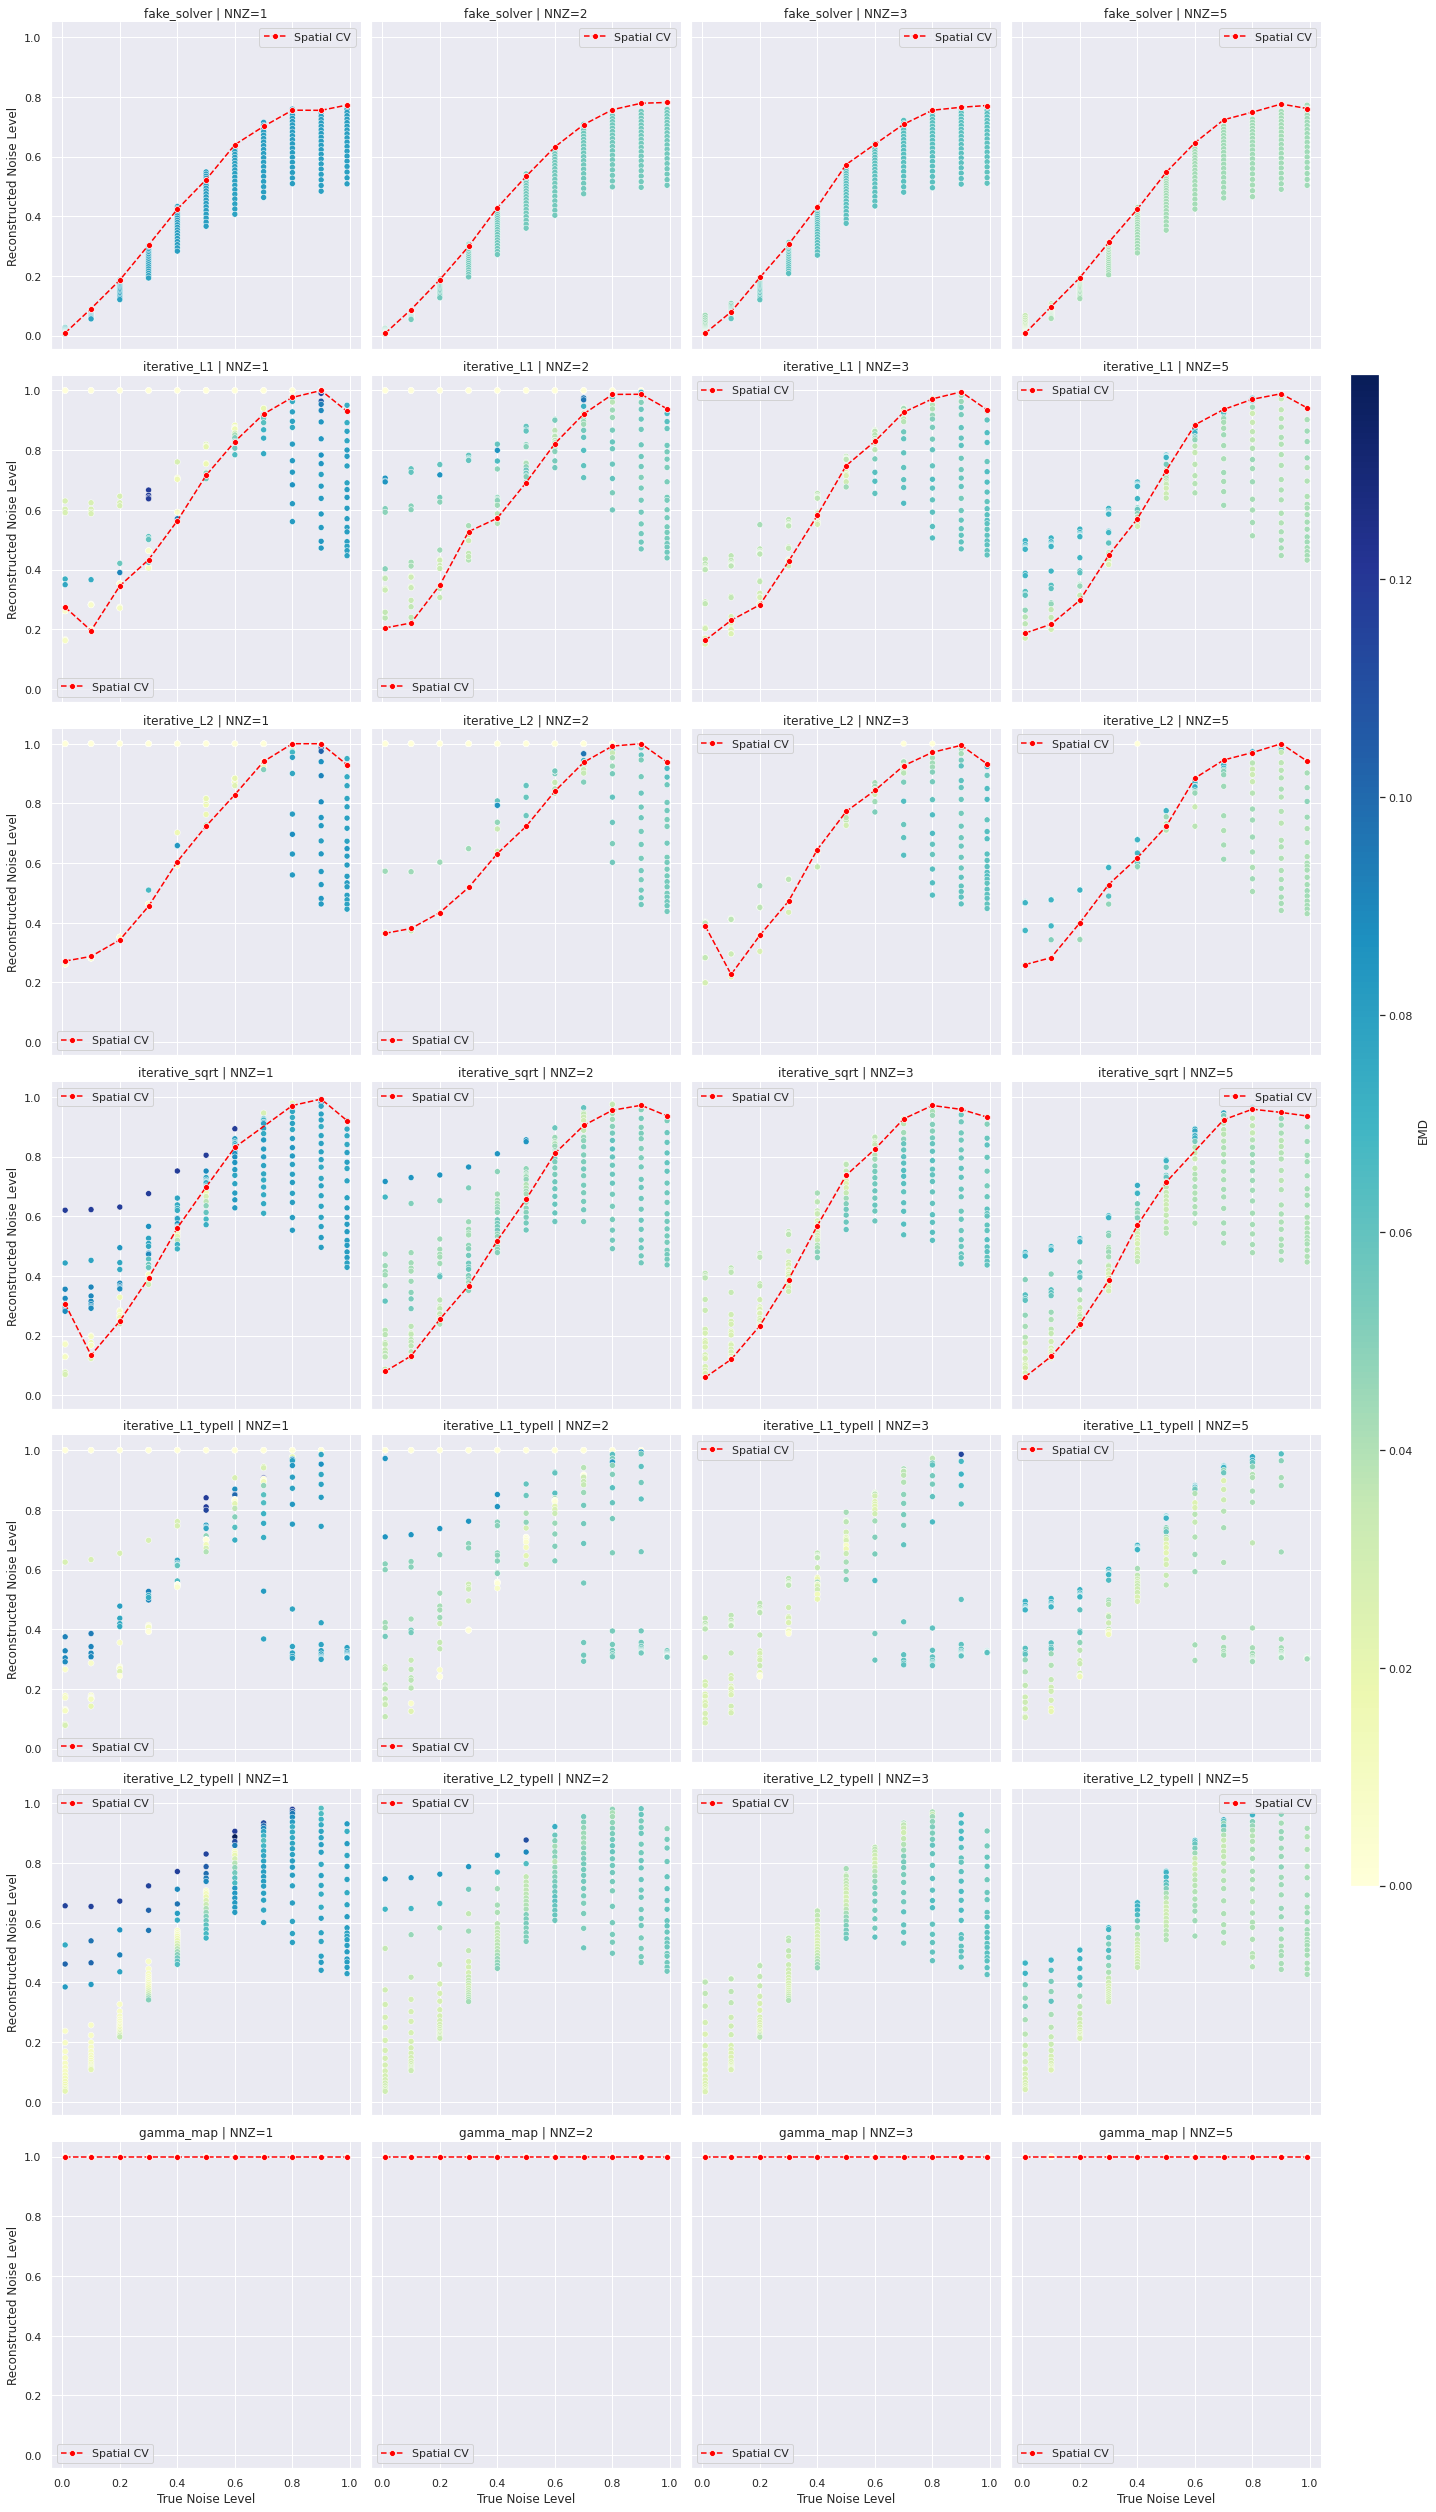

In [86]:
g = sns.relplot(col='nnz', row="estimator", x='alpha', y="reconstructed_noise", hue="emd", data=df_results_fixed, kind="scatter", legend=False, palette='YlGnBu')


# Make space for the colorbar
g.fig.subplots_adjust(right=.92)
# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])
# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=df_results_fixed['emd'].min(), vmax=df_results_fixed['emd'].max(), cmap='YlGnBu')
# Draw the colorbar
g.fig.colorbar(points, cax=cax, label='EMD')
g.set_axis_labels("True Noise Level", "Reconstructed Noise Level")
g.set_titles(col_template="NNZ={col_name}", row_template="{row_name}")


# adding spatialCV
axes = g.axes.flatten()
import itertools
a = [[i]*len(df_results_fixed_with_spatial_cv['nnz'].unique()) for i in df_results_fixed.estimator.unique()]
est = list(itertools.chain(*a))
a = [list(df_results_fixed['nnz'].unique())*len(df_results_fixed_with_spatial_cv['estimator'].unique())]
nnz = list(itertools.chain(*a))
# iterate through each axes
for i, ax in enumerate(axes):
    data = df_results_fixed_with_spatial_cv[(df_results_fixed_with_spatial_cv['estimator']==est[i]) & (df_results_fixed_with_spatial_cv['nnz']==nnz[i])]
    sns.lineplot(data=data, x='alpha', y='reconstructed_noise', ax=ax, color='red', label='Spatial CV', linestyle='--', marker='o')

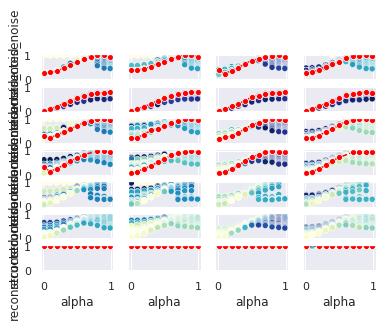

In [19]:
sns.set()
yticks = np.linspace(min(df_results_fixed.reconstructed_noise), max(df_results_fixed.reconstructed_noise)+1, 10)
# tips = sns.load_dataset("tips")
# plt.figure(figsize=(12, 12))
# a = len(df_results_fixed['estimator'].unique())
# b = len(df_results_fixed['nnz'].unique())
fig, axs = plt.subplots(a, b, sharey=True, sharex=True)
for e, estimator in enumerate(df_results_fixed['estimator'].unique()):
    temp = df_results_fixed[df_results_fixed['estimator']==estimator]
    spatial_cv_data=df_results_fixed_with_spatial_cv[df_results_fixed_with_spatial_cv['estimator']==estimator]
    
    # fig, axs = plt.subplots(1, len(temp['nnz'].unique()), figsize=(25, 10), sharey=True)

    for i, nnzi in enumerate(temp['nnz'].unique()):
        
        
        data = temp[temp['nnz']==nnzi]
        ax = sns.scatterplot(y="reconstructed_noise", x="alpha", hue="emd",
                            palette='YlGnBu', data=data, ax=axs[e][i], legend=False)
        # set x ticks for each subplot
        # axs[e][i].set_xticks(temp['alpha'].unique())
        # axs[e][i].set_yticks(yticks)
        # # xticks vertical
        # axs[e][i].tick_params(axis='x', rotation=90)
        # # xlabel
        # axs[e][i].set_xlabel('True noise (SNR)')
        # axs[e][i].set_ylabel('Reconstructed noise (SNR)')
        # axs[e][i].set_title(f'NNZ={nnzi}')
        
        # spatial CV regularization parameter in red lineplot
        spatialCV = spatial_cv_data[spatial_cv_data['nnz']==nnzi]
        spatialCV = spatialCV[['estimator__alpha_cv', 'reconstructed_noise', 'alpha']].dropna(axis=0)
        sns.lineplot(x='alpha', y='reconstructed_noise', data=spatialCV, legend=False, linestyle='--', marker='o', color='red', ax=axs[e][i])
        # spatial_cv_data == df_results_fixed_with_spatial_cv[df_results_fixed_with_spatial_cv['estimator']==estimator]
        # spatialCV = spatial_cv_data[['estimator__alpha_cv', 'reconstructed_noise', 'alpha']].dropna(axis=0)
        # spatialCV.plot(x='alpha', y='reconstructed_noise', style='ro--', ax=axs[i], legend=False)
        # axs[i].set_aspect('equal', 'box')

    # norm = plt.Normalize(data['emd'].min(), data['emd'].max())
    # sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
    # sm.set_array([])
    # # fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.2, label='EMD')
    # fig.legend(labels=['Spatial CV'], loc='upper right')
    # # set colorbar label
    # # set title
    # fig.suptitle(f'Benchmark results for {estimator}; fixed ori', fontsize=14)
    # fig.tight_layout()



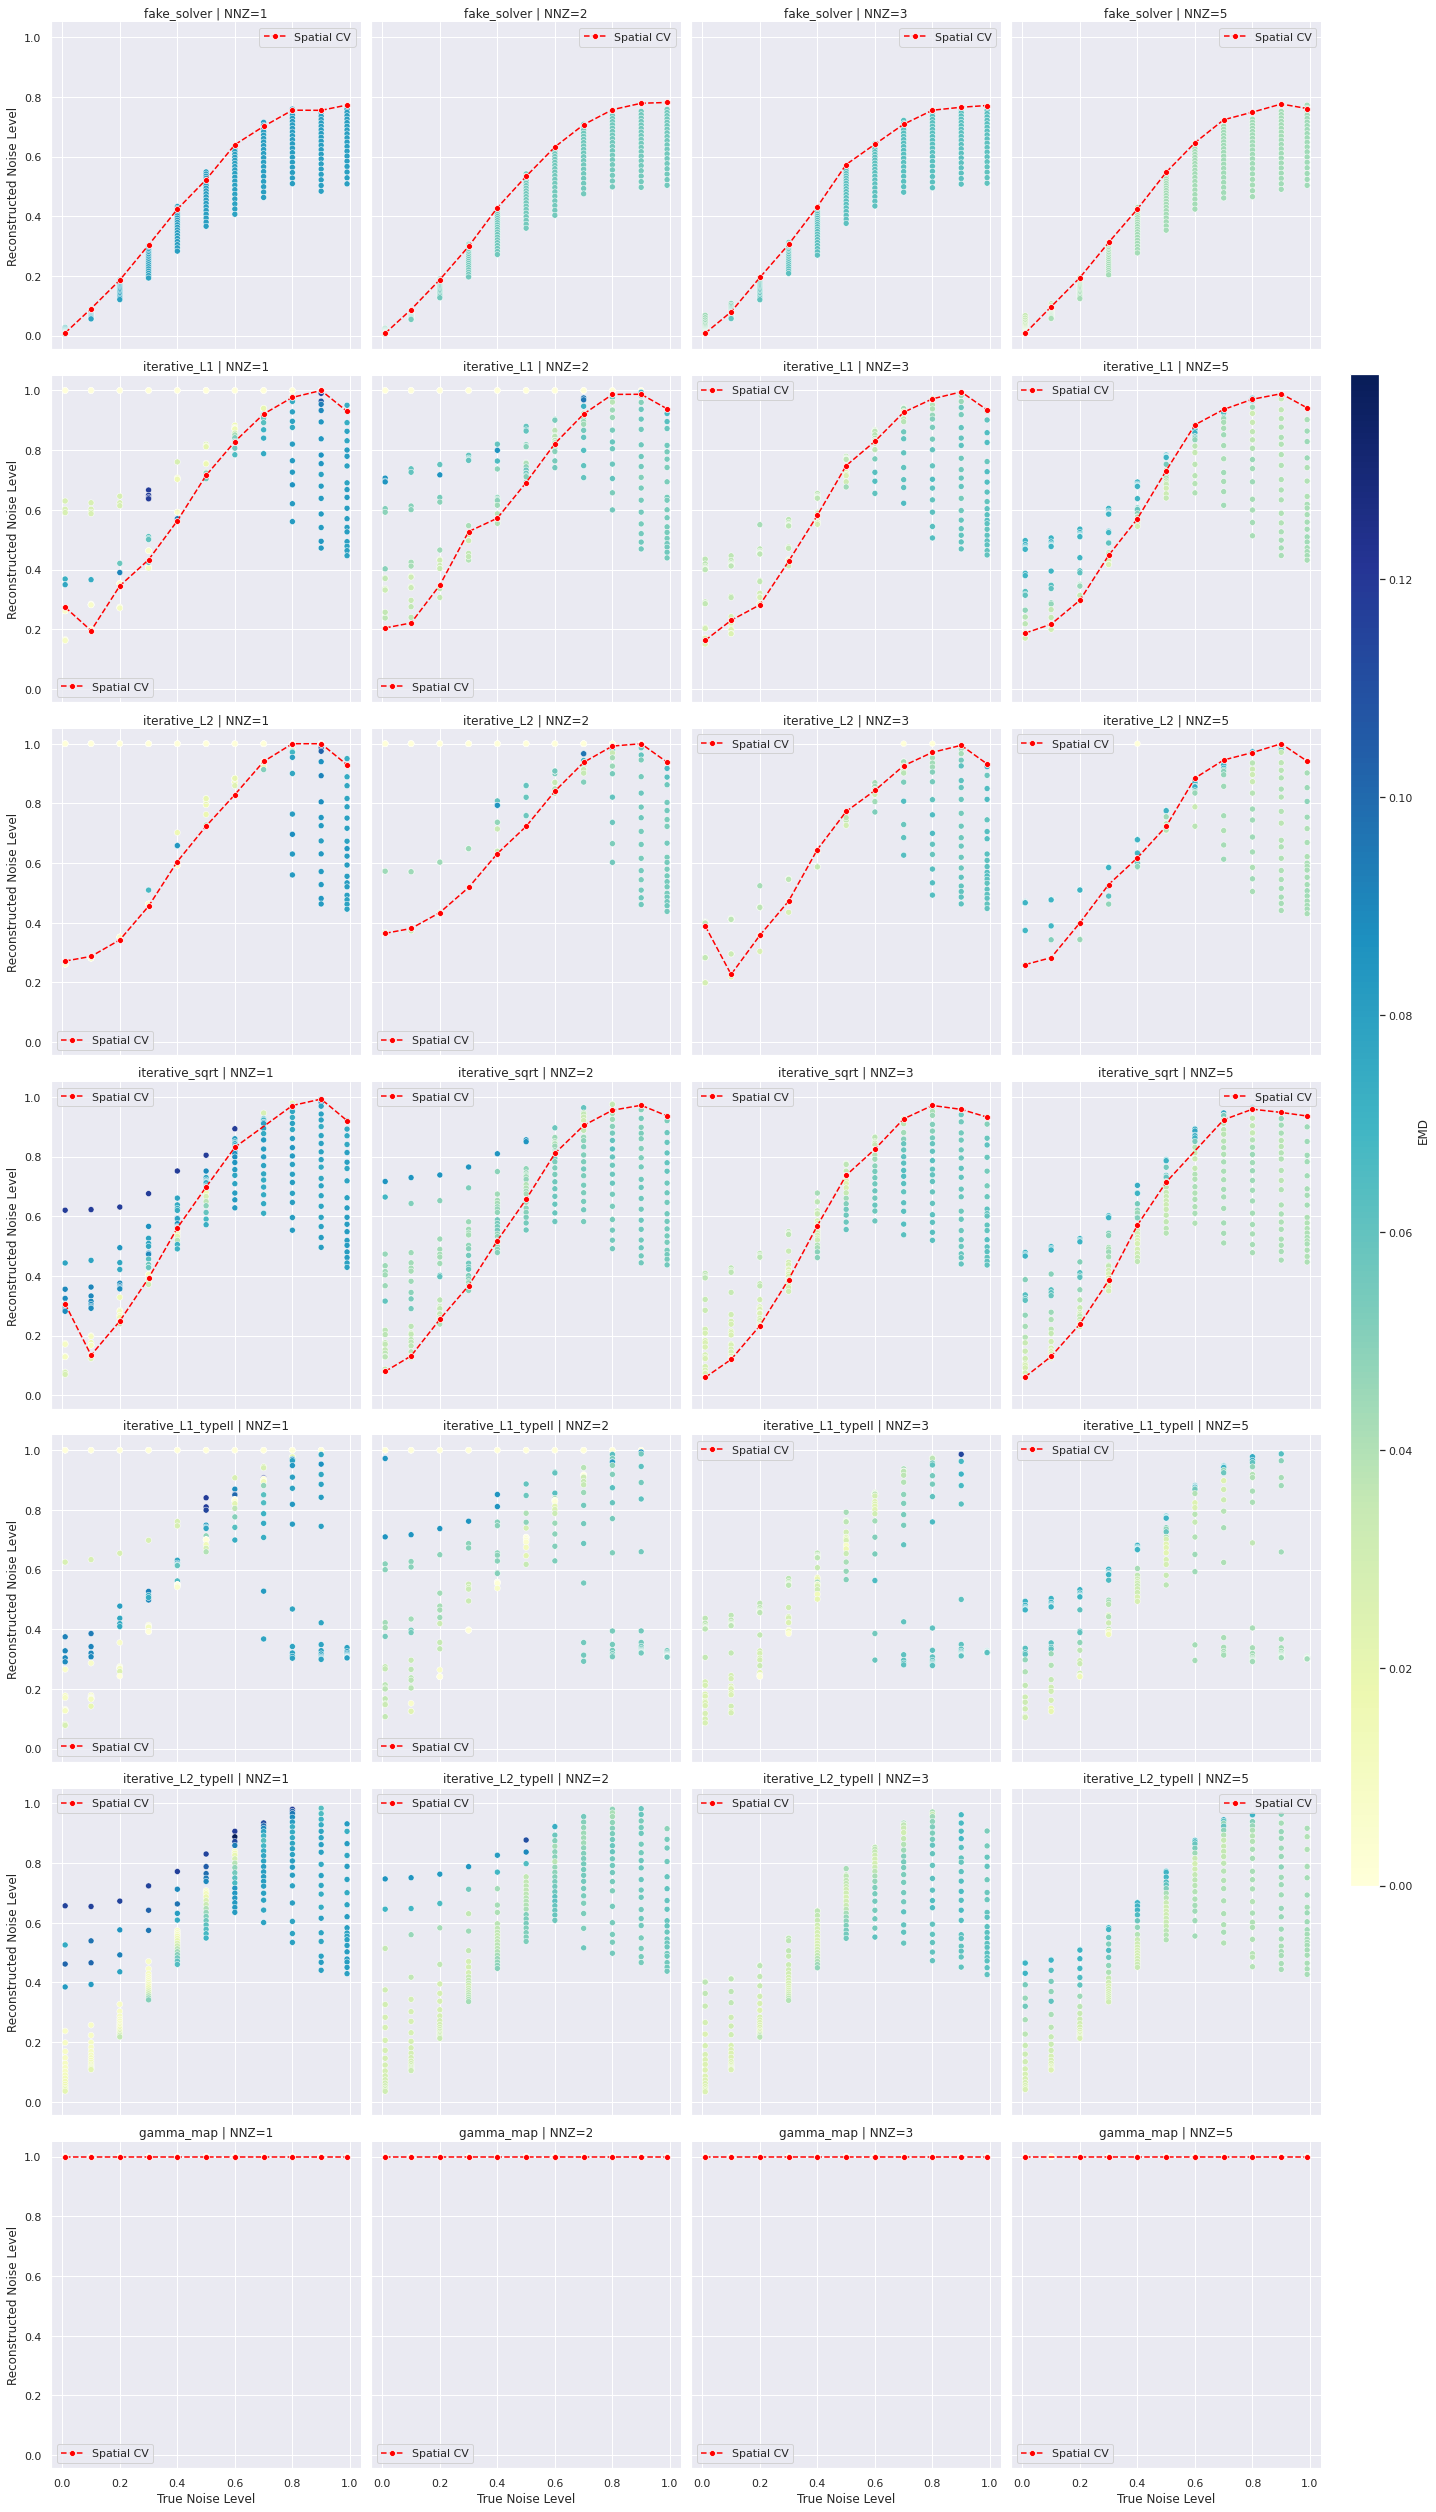

In [85]:
g = sns.relplot(col='nnz', row="estimator", x='alpha', y="reconstructed_noise", hue="emd", data=df_results_fixed, kind="scatter", legend=False, palette='YlGnBu')


# Make space for the colorbar
g.fig.subplots_adjust(right=.92)
# Define a new Axes where the colorbar will go
cax = g.fig.add_axes([.94, .25, .02, .6])
# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=df_results_fixed['emd'].min(), vmax=df_results_fixed['emd'].max(), cmap='YlGnBu')
# Draw the colorbar
g.fig.colorbar(points, cax=cax, label='EMD')
g.set_axis_labels("True Noise Level", "Reconstructed Noise Level")
g.set_titles(col_template="NNZ={col_name}", row_template="{row_name}")


# adding spatialCV
axes = g.axes.flatten()
import itertools
a = [[i]*len(df_results_fixed_with_spatial_cv['nnz'].unique()) for i in df_results_fixed.estimator.unique()]
est = list(itertools.chain(*a))
a = [list(df_results_fixed['nnz'].unique())*len(df_results_fixed_with_spatial_cv['estimator'].unique())]
nnz = list(itertools.chain(*a))
# iterate through each axes
for i, ax in enumerate(axes):
    data = df_results_fixed_with_spatial_cv[(df_results_fixed_with_spatial_cv['estimator']==est[i]) & (df_results_fixed_with_spatial_cv['nnz']==nnz[i])]
    sns.lineplot(data=data, x='alpha', y='reconstructed_noise', ax=ax, color='red', label='Spatial CV', linestyle='--', marker='o')

In [82]:
axes = g.axes.flatten()
for i, ax in enumerate(axes):
    print(i, ax)

list(df_results_fixed_with_spatial_cv.estimator.unique())

import itertools
a = [[i]*len(df_results_fixed_with_spatial_cv['nnz'].unique()) for i in df_results_fixed.estimator.unique()]
est = list(itertools.chain(*a))
a = [list(df_results_fixed['nnz'].unique())*len(df_results_fixed_with_spatial_cv['estimator'].unique())]
nnz = list(itertools.chain(*a))


0 AxesSubplot(0.0379688,0.859824;0.21531x0.129541)
1 AxesSubplot(0.260209,0.859824;0.21531x0.129541)
2 AxesSubplot(0.48245,0.859824;0.21531x0.129541)
3 AxesSubplot(0.70469,0.859824;0.21531x0.129541)
4 AxesSubplot(0.0379688,0.719649;0.21531x0.129541)
5 AxesSubplot(0.260209,0.719649;0.21531x0.129541)
6 AxesSubplot(0.48245,0.719649;0.21531x0.129541)
7 AxesSubplot(0.70469,0.719649;0.21531x0.129541)
8 AxesSubplot(0.0379688,0.579473;0.21531x0.129541)
9 AxesSubplot(0.260209,0.579473;0.21531x0.129541)
10 AxesSubplot(0.48245,0.579473;0.21531x0.129541)
11 AxesSubplot(0.70469,0.579473;0.21531x0.129541)
12 AxesSubplot(0.0379688,0.439297;0.21531x0.129541)
13 AxesSubplot(0.260209,0.439297;0.21531x0.129541)
14 AxesSubplot(0.48245,0.439297;0.21531x0.129541)
15 AxesSubplot(0.70469,0.439297;0.21531x0.129541)
16 AxesSubplot(0.0379688,0.299121;0.21531x0.129541)
17 AxesSubplot(0.260209,0.299121;0.21531x0.129541)
18 AxesSubplot(0.48245,0.299121;0.21531x0.129541)
19 AxesSubplot(0.70469,0.299121;0.21531x0.129

28

In [59]:
ax.fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.2, label='EMD')

AttributeError: 'FacetGrid' object has no attribute 'get_figure'

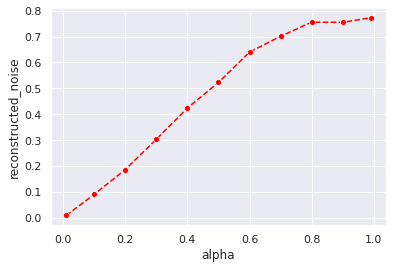

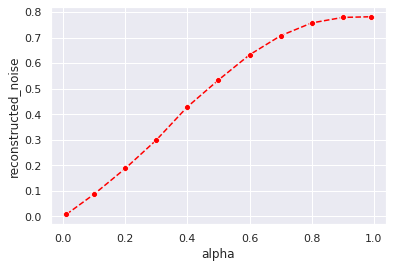

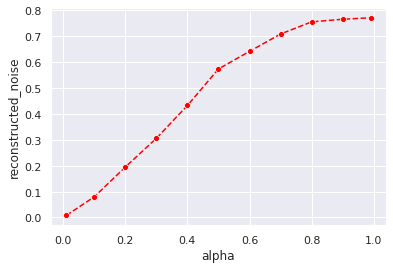

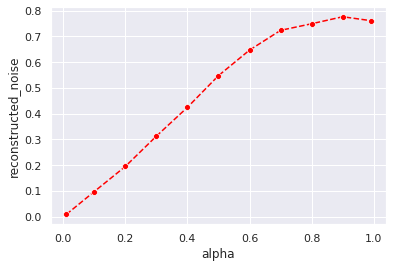

In [64]:
# spatial CV regularization parameter in red lineplot
# spatial_cv_data == df_results_fixed_with_spatial_cv[df_results_fixed_with_spatial_cv['estimator']==estimator]
# spatialCV = spatial_cv_data[['estimator__alpha_cv', 'reconstructed_noise', 'alpha']].dropna(axis=0)
# sns.scatterplot(x='alpha', y='reconstructed_noise', data=spatialCV, style='ro--', legend=False)
for nnzi in df_results_fixed.nnz.unique():
    spatial_cv_data=df_results_fixed_with_spatial_cv[df_results_fixed_with_spatial_cv['estimator']=='fake_solver']
    spatial_cv_data = spatial_cv_data[spatial_cv_data['nnz']==nnzi]
    spatialCV = spatial_cv_data[['estimator__alpha_cv', 'reconstructed_noise', 'alpha']].dropna(axis=0)
    plt.figure()
    sns.lineplot(x='alpha', y='reconstructed_noise', data=spatialCV, legend=False, linestyle='--', marker='o', color='red')
# spatialCV


In [84]:
# for fakeSolver
METRIC_NAMES = ['euclidean_distance', 'mse', 'emd', 'f1']

# benchmark_files_fixed = [f for f in os.listdir('bsi_zoo/data/') if ('pkl' in f) and ('fixed' in f) and ('20313' in f or '166' in f) and ('CV' not in f) and 'log' in f]
benchmark_files_fixed = ['benchmark_data_CC120166_fixed_May-18-2023_1613.pkl']
# benchmark_files_fixed = ['benchmark_data_CC120166_fixed_eloreta.pkl']
benchmark_files_free = [f for f in os.listdir('bsi_zoo/data/') if 'pkl' in f and 'free' in f and ('166'  in f or '313' in f) and 'CV' not in f and 'log' in f]

dfs_fixed = [pd.read_pickle(f'bsi_zoo/data/{file}') for file in benchmark_files_fixed]
dfs_free = [pd.read_pickle(f'bsi_zoo/data/{file}') for file in benchmark_files_free]

df_results_fixed = pd.concat(dfs_fixed)
df_results_free = pd.concat(dfs_free)
df_results_fixed

estimator  euclidean_distance      mse       emd        f1  \
0    fake_solver            0.043015  0.00011  0.062700  0.000427   
1    fake_solver            0.043015  0.00011  0.062623  0.000427   
2    fake_solver            0.043015  0.00011  0.062549  0.000427   
3    fake_solver            0.043015  0.00011  0.062480  0.000427   
4    fake_solver            0.043015  0.00011  0.062417  0.000427   
..           ...                 ...      ...       ...       ...   
831    gamma_map                 NaN  0.00084  0.000000  0.000000   
832    gamma_map                 NaN  0.00084  0.000000  0.000000   
833    gamma_map                 NaN  0.00084  0.000000  0.000000   
834    gamma_map                 NaN  0.00084  0.000000  0.000000   
835    gamma_map                 NaN  0.00084  0.000000  0.000000   

     reconstructed_noise  alpha cov_type  n_sensors  n_sources  n_times  nnz  \
0               0.029307   0.99     diag         50        200       10    1   
1               0.027305   0.99     diag         50        200       10    1   
2               0.025456   0.99     diag         50        200       10    1   
3               0.023752   0.99     diag         50        200       10    1   
4               0.022182   0.99     diag         50        200       10    1   
..                   ...    ...      ...        ...        ...      ...  ...   
831             1.000000   0.01     full         50        200       10    5   
832             1.000000   0.01     full         50        200       10    5   
833             1.000000   0.01     full         50        200       10    5   
834             1.000000   0.01     full         50        200       10    5   
835             1.000000   0.01     full         50        200       10    5   

    orientation_type                           path_to_leadfield  \
0              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
1              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
2              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
3              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
4              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
..               ...                                         ...   
831            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
832            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
833            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
834            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
835            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   

     estimator__alpha error  
0            0.885867   NaN  
1            0.784760   NaN  
2            0.695193   NaN  
3            0.615848   NaN  
4            0.545559   NaN  
..                ...   ...  
831          0.162378   NaN  
832          0.143845   NaN  
833          0.127427   NaN  
834          0.112884   NaN  
835          0.100000   NaN  

[7524 rows x 16 columns]

In [15]:
import scipy.io as sio
for i, df in enumerate(dfs_free):
    print(benchmark_files_free[i])
    df['alpha'] = 1-df['alpha'].astype('float')
    OutData = {} 

    # convert DF to dictionary before loading to your dictionary
    OutData['Obj'] = df.to_dict('list')

    sio.savemat(f'./bsi_zoo/data/{benchmark_files_free[i][:-4]}.mat',OutData)
# /home/anujanegi/tj/bdsg/BSI-Zoo/bsi_zoo/data

benchmark_data_CC120166_free_logSNR_fakeSolver.pkl
benchmark_data_CC120313_free_logSNR_fakeSolver.pkl


In [13]:
benchmark_files_free

['benchmark_data_CC120166_free_logSNR_fakeSolver.pkl',
 'benchmark_data_CC120313_free_logSNR_fakeSolver.pkl']

In [39]:
# # removed benchmarks that don't have all metrics.
# df_results_fixed = df_results_fixed.dropna(axis=0, how='any')
# df_results_free = df_results_free.dropna(axis=0, how='any')

# df_results_free.shape

(38847, 15)

In [18]:
df_results_fixed['alpha'].unique()

array([1.00000000e-04, 1.35369160e-02, 2.78309861e-02, 4.29719535e-02,
       5.90665281e-02, 7.62429519e-02, 9.46572132e-02, 1.14501677e-01,
       1.36017355e-01, 1.59511835e-01, 1.85386306e-01, 2.14177874e-01,
       2.46628860e-01, 2.83806816e-01, 3.27327544e-01, 3.79809616e-01,
       4.45926364e-01, 5.35346558e-01, 6.74064103e-01, 1.00000000e+00])

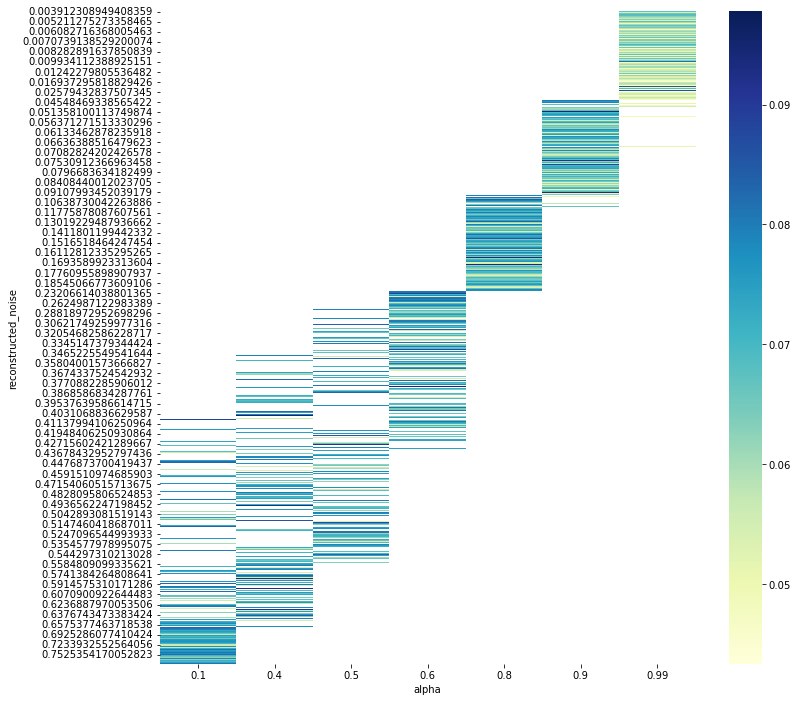

In [83]:
plt.figure(figsize=(12, 12))

ax = sns.heatmap(data, annot=False, fmt=".2f", cmap="YlGnBu")


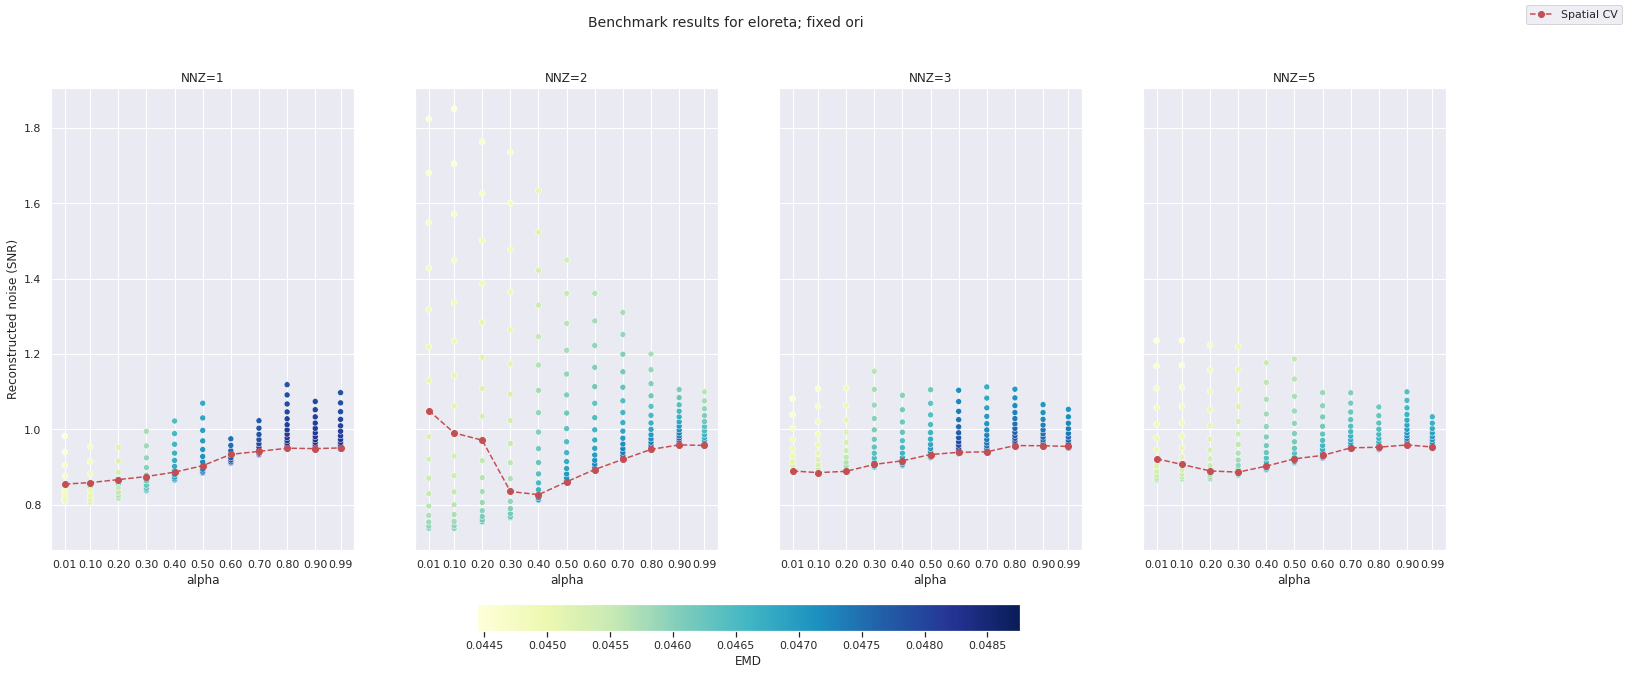

In [83]:
# highest alpha should highest value in leadfield 
# x.T @ x plus alpha inverse

# just testing
df_results_fixed['alpha'] = 1-df_results_fixed['alpha'].astype(float)

sns.set()
# tips = sns.load_dataset("tips")
# plt.figure(figsize=(12, 12))
for estimator in df_results_fixed['estimator'].unique():
    temp = df_results_fixed[df_results_fixed['estimator']==estimator]
    fig, axs = plt.subplots(1, len(temp['nnz'].unique()), figsize=(25, 10), sharey=True)
    for i, nnzi in enumerate(temp['nnz'].unique()):
        
        data = temp[temp['nnz']==nnzi]
        ax = sns.scatterplot(y="reconstructed_noise", x="alpha", hue="emd",
                            palette='YlGnBu', data=data, ax=axs[i], legend=False)
        # set x ticks for each subplot
        axs[i].set_xticks(temp['alpha'].unique())
        # xticks vertical
        axs[i].tick_params(axis='x', rotation=90)
        # xlabel
        axs[i].set_xlabel('True noise (SNR)')
        axs[i].set_ylabel('Reconstructed noise (SNR)')
        axs[i].set_title(f'NNZ={nnzi}')
        
        # spatial CV regularization parameter in red lineplot
        spatialCV = data[['alpha', 'reconstructed_noise', 'mse']].dropna(axis=0)
        spatialCV.loc[spatialCV.groupby(['alpha'])['mse'].idxmin()].plot(x='alpha', y='reconstructed_noise', style='ro--', ax=axs[i], legend=False)

    norm = plt.Normalize(data['emd'].min(), data['emd'].max())
    sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, label='EMD')
    fig.legend(labels=['Spatial CV'], loc='upper right')
    # set colorbar label
    # set title
    fig.suptitle(f'Benchmark results for {estimator}; fixed ori', fontsize=14)

    # axs.figure.colorbar(sm)

    plt.show()

#TODO
# ipynb for specific occurences that are wierd
# seed data generation
# check spatialCV again
# 1 run 1 subj
# fix axis to quadractic
# fix labelsspecific occurences that are wierd
# seed data generation
# check spatialCV again
# fix axis to quadractic
# fix labels
# manual limit and ticks for axis
# scale heatmap colors to all graphs
# do actual spatial CV
# check gamma map

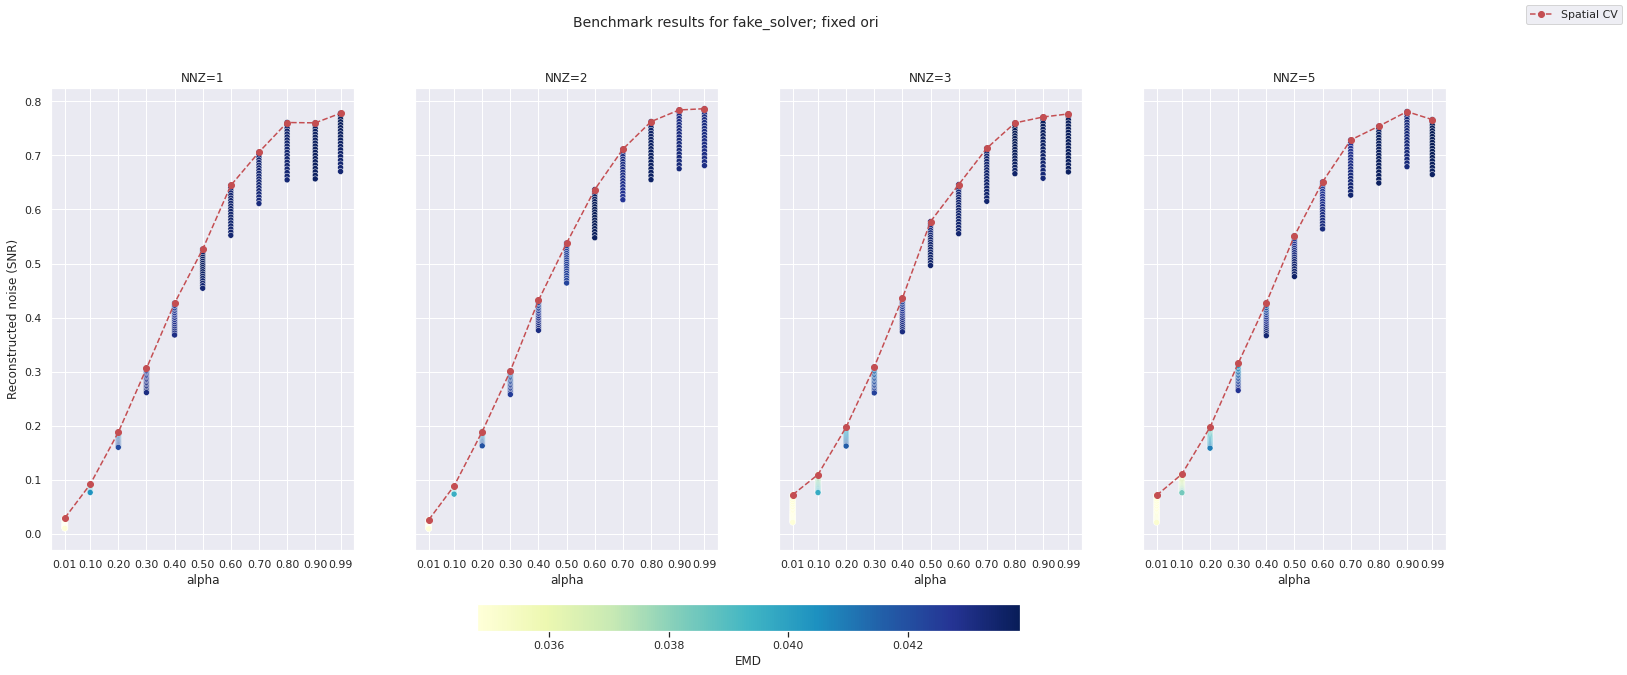

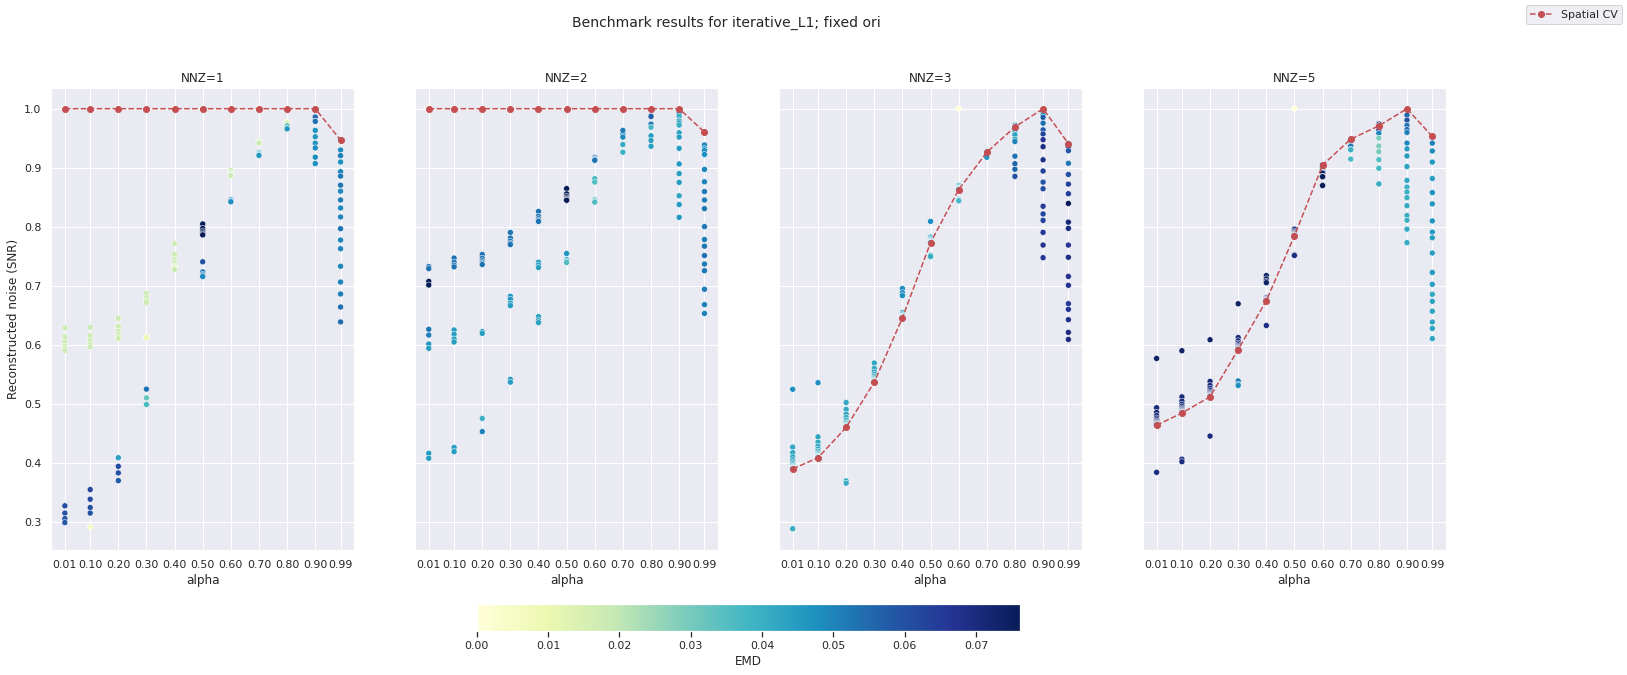

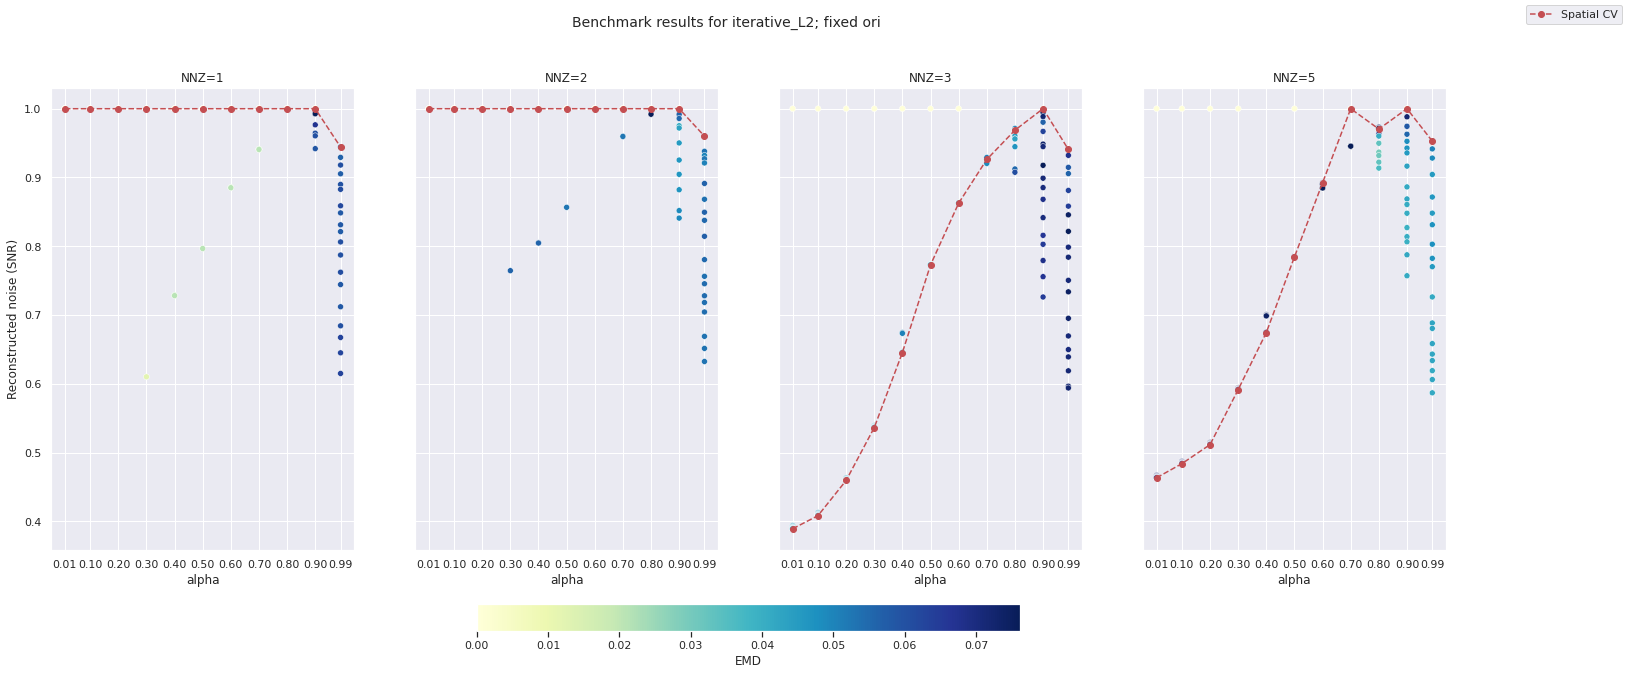

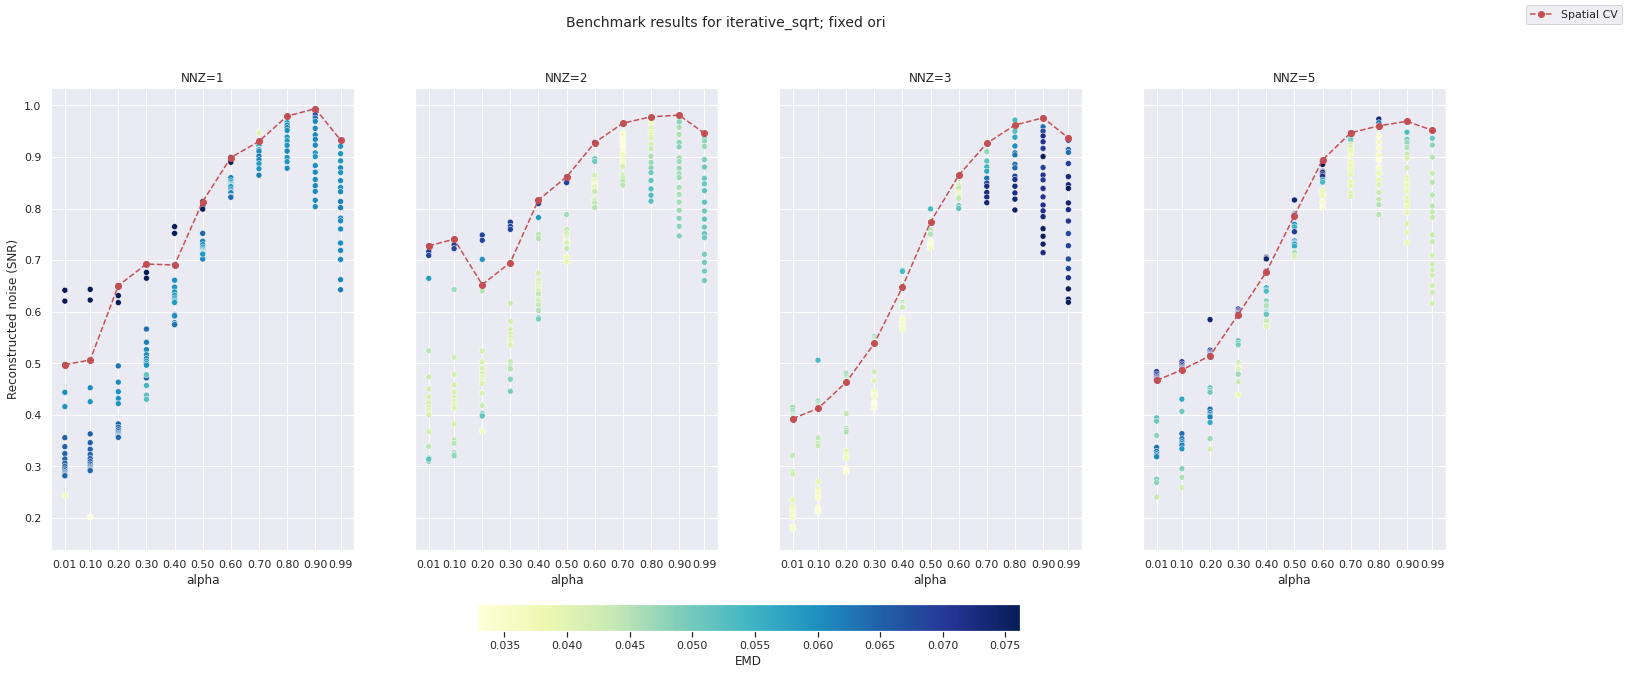

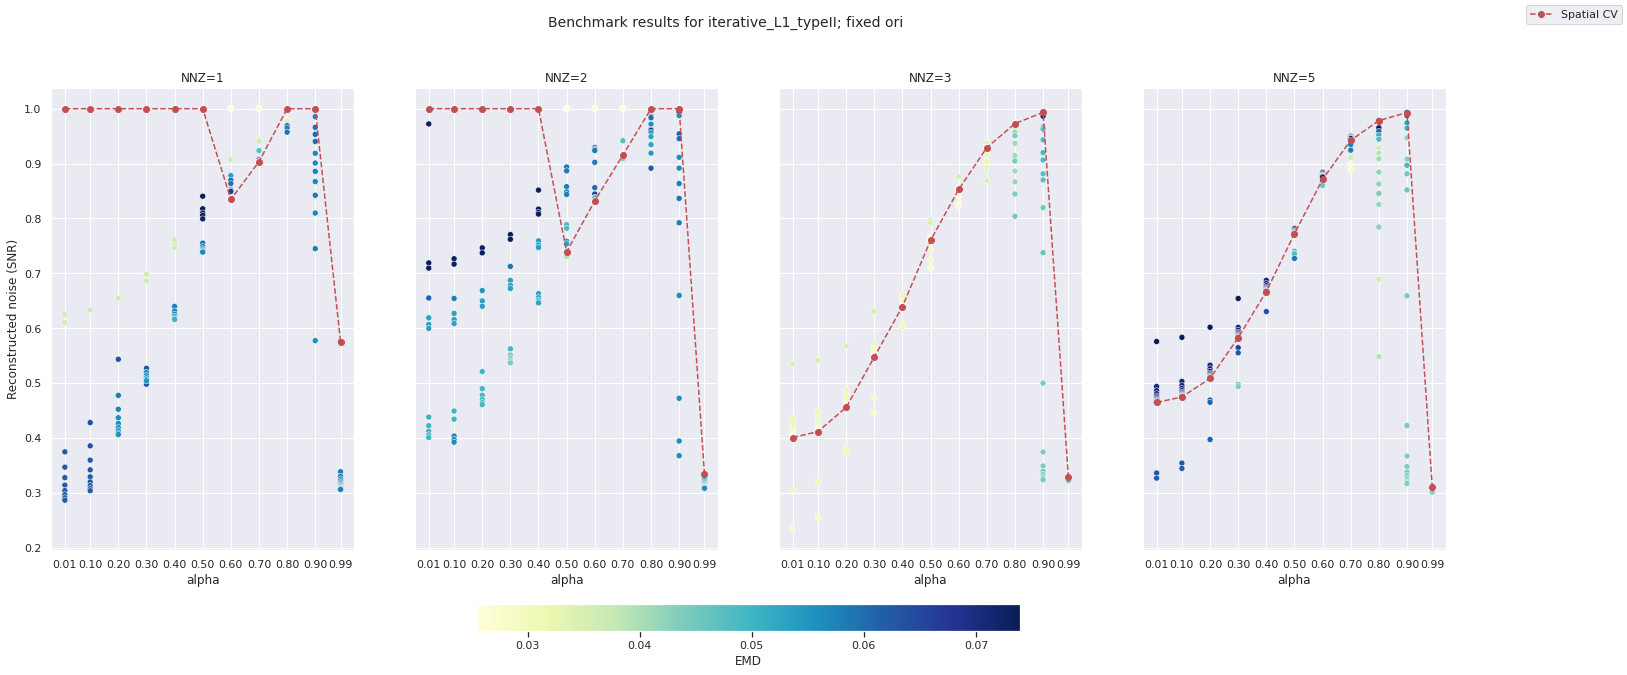

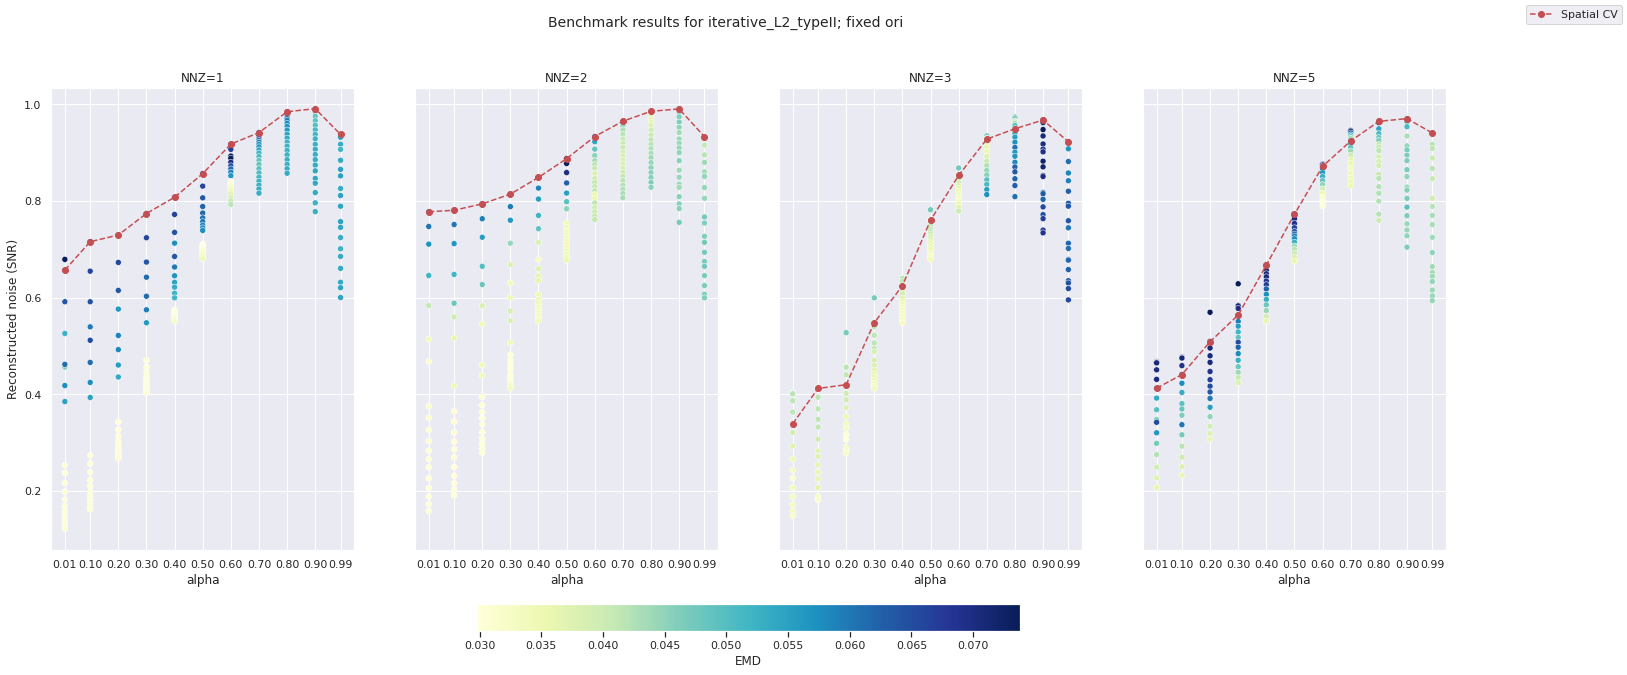

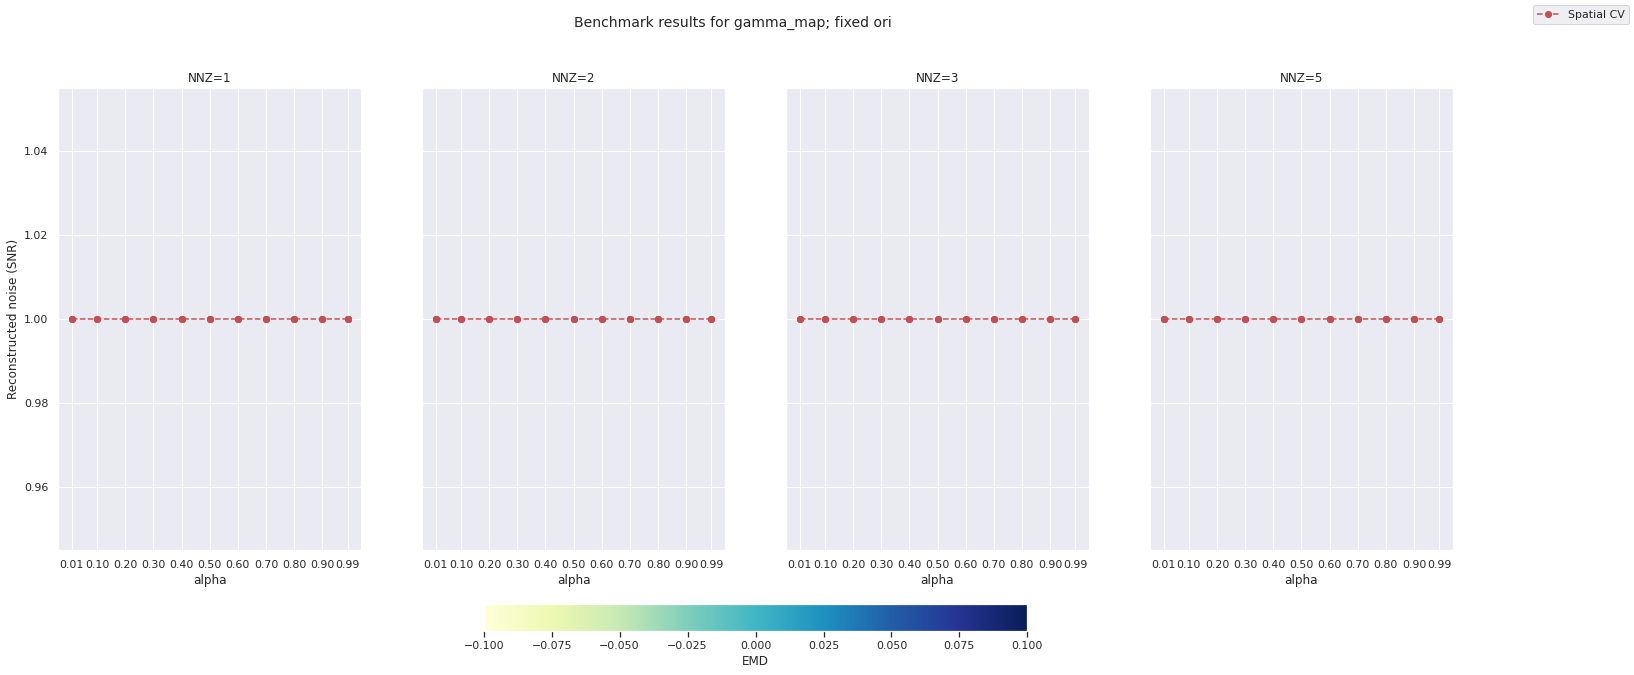

In [85]:
# highest alpha should highest value in leadfield 
# x.T @ x plus alpha inverse

# just testing
df_results_fixed['alpha'] = 1-df_results_fixed['alpha'].astype(float)

sns.set()
# tips = sns.load_dataset("tips")
# plt.figure(figsize=(12, 12))
for estimator in df_results_fixed['estimator'].unique():
    temp = df_results_fixed[df_results_fixed['estimator']==estimator]
    fig, axs = plt.subplots(1, len(temp['nnz'].unique()), figsize=(25, 10), sharey=True)
    for i, nnzi in enumerate(temp['nnz'].unique()):
        
        data = temp[temp['nnz']==nnzi]
        ax = sns.scatterplot(y="reconstructed_noise", x="alpha", hue="emd",
                            palette='YlGnBu', data=data, ax=axs[i], legend=False)
        # set x ticks for each subplot
        axs[i].set_xticks(temp['alpha'].unique())
        # xticks vertical
        axs[i].tick_params(axis='x', rotation=90)
        # xlabel
        axs[i].set_xlabel('True noise (SNR)')
        axs[i].set_ylabel('Reconstructed noise (SNR)')
        axs[i].set_title(f'NNZ={nnzi}')
        
        # spatial CV regularization parameter in red lineplot
        spatialCV = data[['alpha', 'reconstructed_noise', 'mse']].dropna(axis=0)
        spatialCV.loc[spatialCV.groupby(['alpha'])['mse'].idxmin()].plot(x='alpha', y='reconstructed_noise', style='ro--', ax=axs[i], legend=False)

    norm = plt.Normalize(data['emd'].min(), data['emd'].max())
    sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, label='EMD')
    fig.legend(labels=['Spatial CV'], loc='upper right')
    # set colorbar label
    # set title
    fig.suptitle(f'Benchmark results for {estimator}; fixed ori', fontsize=14)

    # axs.figure.colorbar(sm)

    plt.show()

#TODO
# ipynb for specific occurences that are wierd
# seed data generation
# check spatialCV again
# 1 run 1 subj
# fix axis to quadractic
# fix labelsspecific occurences that are wierd
# seed data generation
# check spatialCV again
# fix axis to quadractic
# fix labels
# report mse test set errror

In [43]:
data = df_results_free[df_results_free['nnz']==1]

a = data.where(data['alpha']==0.1)
a

estimator  euclidean_distance  mse  emd  f1  reconstructed_noise  alpha  \
0           NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
1           NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
2           NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
3           NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
4           NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
...         ...                 ...  ...  ...  ..                  ...    ...   
11475       NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
11476       NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
11477       NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
11478       NaN                 NaN  NaN  NaN NaN                  NaN    NaN   
11479       NaN                 NaN  NaN  NaN NaN                  NaN    NaN   

      cov_type  n_sensors  n_sources  n_times  nnz orientation_type  \
0          NaN        NaN        NaN      NaN  NaN              NaN   
1          NaN        NaN        NaN      NaN  NaN              NaN   
2          NaN        NaN        NaN      NaN  NaN              NaN   
3          NaN        NaN        NaN      NaN  NaN              NaN   
4          NaN        NaN        NaN      NaN  NaN              NaN   
...        ...        ...        ...      ...  ...              ...   
11475      NaN        NaN        NaN      NaN  NaN              NaN   
11476      NaN        NaN        NaN      NaN  NaN              NaN   
11477      NaN        NaN        NaN      NaN  NaN              NaN   
11478      NaN        NaN        NaN      NaN  NaN              NaN   
11479      NaN        NaN        NaN      NaN  NaN              NaN   

      path_to_leadfield  estimator__alpha  
0                   NaN               NaN  
1                   NaN               NaN  
2                   NaN               NaN  
3                   NaN               NaN  
4                   NaN               NaN  
...                 ...               ...  
11475               NaN               NaN  
11476               NaN               NaN  
11477               NaN               NaN  
11478               NaN               NaN  
11479               NaN               NaN  

[6160 rows x 15 columns]

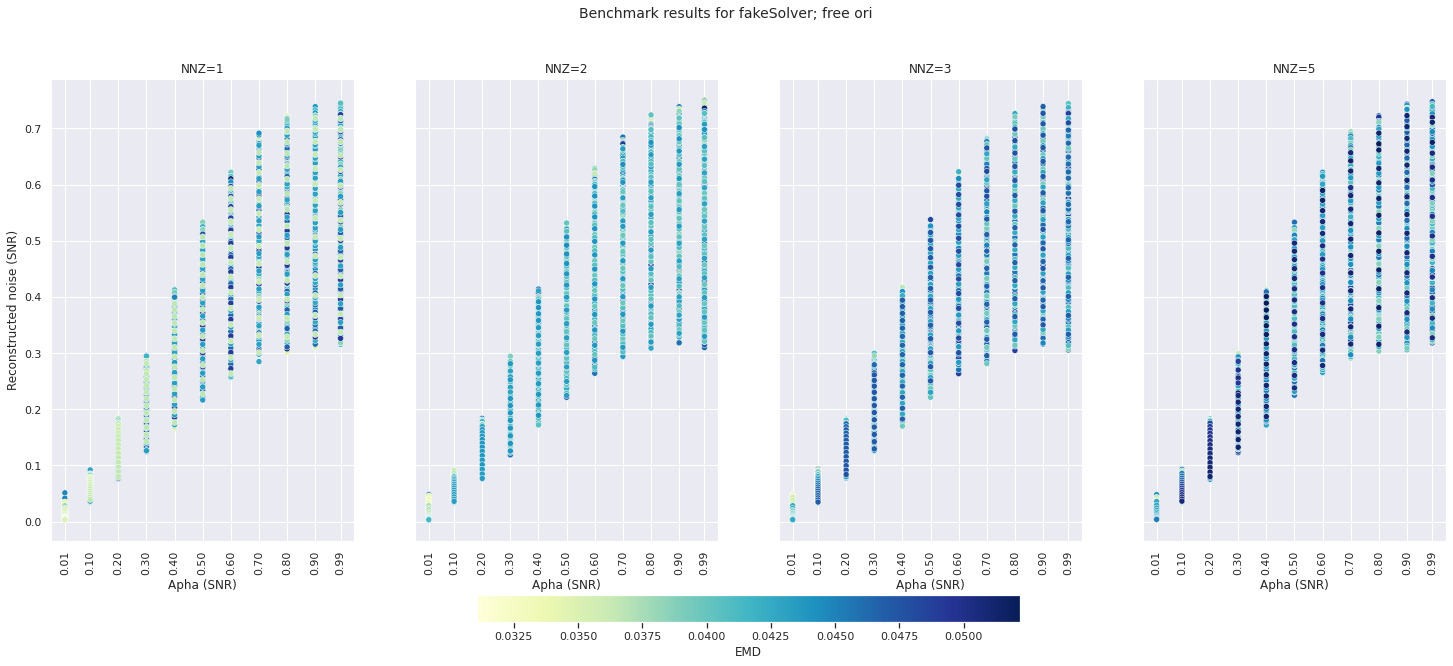

In [31]:
df_results_free['alpha'] = 1-df_results_free['alpha'].astype(float)

sns.set()
# tips = sns.load_dataset("tips")
# plt.figure(figsize=(12, 12))
fig, axs = plt.subplots(1, len(df_results_free['nnz'].unique()), figsize=(25, 10), sharey=True)
for i, nnzi in enumerate(df_results_fixed['nnz'].unique()):
    
    data = df_results_free[df_results_free['nnz']==nnzi]
    ax = sns.scatterplot(y="reconstructed_noise", x="alpha", hue="emd",
                        palette='YlGnBu', data=data, ax=axs[i], legend=False)
    # set x ticks for each subplot
    axs[i].set_xticks(df_results_free['alpha'].unique())
    # xticks vertical
    axs[i].tick_params(axis='x', rotation=90)
    # xlabel
    axs[i].set_xlabel('Apha (SNR)')
    axs[i].set_ylabel('Reconstructed noise (SNR)')
    axs[i].set_title(f'NNZ={nnzi}')

norm = plt.Normalize(data['emd'].min(), data['emd'].max())
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.1, label='EMD')
# set colorbar label
# set title
fig.suptitle('Benchmark results for fakeSolver; free ori', fontsize=14)

# axs.figure.colorbar(sm)

plt.show()


In [47]:
test = df_results_fixed[df_results_fixed['estimator'] == 'iterative_L1']
temp = test[['alpha', 'reconstructed_noise', 'euclidean', 'emd']].dropna(axis=0)
# temp.loc[temp.groupby(['alpha'])['emd'].idxmin()]
test

estimator  euclidean_distance         mse       emd   f1  \
0    iterative_L1                 NaN    0.000109  0.000000  0.0   
1    iterative_L1                 NaN    0.000109  0.000000  0.0   
2    iterative_L1                 NaN    0.000109  0.000000  0.0   
3    iterative_L1                 NaN    0.000109  0.000000  0.0   
4    iterative_L1                 NaN    0.000109  0.000000  0.0   
..            ...                 ...         ...       ...  ...   
831  iterative_L1            0.074352  166.740108  0.043312  0.0   
832  iterative_L1            0.073983  208.621899  0.042770  0.0   
833  iterative_L1            0.079477  257.363722  0.042540  0.0   
834  iterative_L1            0.076675  263.714347  0.042600  0.0   
835  iterative_L1            0.082980  301.207211  0.042563  0.0   

     reconstructed_noise  alpha cov_type  n_sensors  n_sources  n_times  nnz  \
0               1.000000   0.99     diag         50        200       10    1   
1               1.000000   0.99     diag         50        200       10    1   
2               1.000000   0.99     diag         50        200       10    1   
3               1.000000   0.99     diag         50        200       10    1   
4               1.000000   0.99     diag         50        200       10    1   
..                   ...    ...      ...        ...        ...      ...  ...   
831             0.673691   0.01     diag         50        200       10    5   
832             0.656924   0.01     diag         50        200       10    5   
833             0.638637   0.01     diag         50        200       10    5   
834             0.627745   0.01     diag         50        200       10    5   
835             0.610491   0.01     diag         50        200       10    5   

    orientation_type                           path_to_leadfield  \
0              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
1              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
2              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
3              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
4              fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
..               ...                                         ...   
831            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
832            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
833            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
834            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
835            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   

     estimator__alpha error  
0            0.885867   NaN  
1            0.784760   NaN  
2            0.695193   NaN  
3            0.615848   NaN  
4            0.545559   NaN  
..                ...   ...  
831          0.162378   NaN  
832          0.143845   NaN  
833          0.127427   NaN  
834          0.112884   NaN  
835          0.100000   NaN  

[836 rows x 16 columns]

In [66]:
test = df_results_fixed[df_results_fixed['estimator'] == 'fake_solver'][df_results_fixed['nnz']==1]
test

estimator  euclidean_distance       mse       emd        f1  \
0      fake_solver            0.043015  0.000110  0.062522  0.000427   
1      fake_solver            0.043015  0.000110  0.062321  0.000427   
2      fake_solver            0.043015  0.000110  0.062198  0.000427   
3      fake_solver            0.043015  0.000110  0.062160  0.000427   
4      fake_solver            0.043015  0.000111  0.062214  0.000427   
...            ...                 ...       ...       ...       ...   
17495  fake_solver            0.087873  0.630224  0.078019  0.000427   
17496  fake_solver            0.087873  0.980982  0.078070  0.000427   
17497  fake_solver            0.087873  1.505530  0.078164  0.000427   
17498  fake_solver            0.087873  2.280376  0.078295  0.000427   
17499  fake_solver            0.087873  3.416414  0.078455  0.000427   

       reconstructed_noise  alpha cov_type  n_sensors  n_sources  n_times  \
0                 0.024770   0.99     diag         50        200       10   
1                 0.019684   0.99     diag         50        200       10   
2                 0.015873   0.99     diag         50        200       10   
3                 0.013060   0.99     diag         50        200       10   
4                 0.011005   0.99     diag         50        200       10   
...                    ...    ...      ...        ...        ...      ...   
17495             0.568973   0.10     diag         50        200       10   
17496             0.536733   0.10     diag         50        200       10   
17497             0.503370   0.10     diag         50        200       10   
17498             0.469163   0.10     diag         50        200       10   
17499             0.434391   0.10     diag         50        200       10   

       nnz orientation_type                           path_to_leadfield  \
0        1            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
1        1            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
2        1            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
3        1            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
4        1            fixed  bsi_zoo/tests/data/lead_field_CC120166.npz   
...    ...              ...                                         ...   
17495    1            fixed  bsi_zoo/tests/data/lead_field_CC120313.npz   
17496    1            fixed  bsi_zoo/tests/data/lead_field_CC120313.npz   
17497    1            fixed  bsi_zoo/tests/data/lead_field_CC120313.npz   
17498    1            fixed  bsi_zoo/tests/data/lead_field_CC120313.npz   
17499    1            fixed  bsi_zoo/tests/data/lead_field_CC120313.npz   

       estimator__alpha  
0              0.662870  
1              0.439397  
2              0.291263  
3              0.193070  
4              0.127980  
...                 ...  
17495          0.016379  
17496          0.010857  
17497          0.007197  
17498          0.004771  
17499          0.003162  

[9800 rows x 15 columns]

In [67]:
# for free orientation
# df_results_fixed.pivot_table('emd', ['estimator', 'nnz', 'reconstructed_noise'], 'alpha')

# SNR vs NNZ
for df_results, orientation in zip([df_results_fixed, df_results_free], ["fixed", "free"]):
    for metric in METRIC_NAMES:
        # data = df_results.pivot_table(metric, ["estimator", "alpha"], "nnz", aggfunc='mean')
        data = df_results_fixed[df_results_fixed['estimator'] == 'fake_solver'][df_results_fixed['nnz']==1].pivot_table('emd', ['reconstructed_noise'], 'alpha', aggfunc='mean')

        from collections import OrderedDict
        plt.figure(figsize=(12, 12))
        df=data
        ax = sns.heatmap(df, annot=True, cmap="YlGnBu")

        ylabel_mapping = OrderedDict()
        for estimator, alpha in df.index:
            ylabel_mapping.setdefault(estimator, [])
            ylabel_mapping[estimator].append(alpha)

        hline = []
        new_ylabels = []
        for estimator, alpha_list in ylabel_mapping.items():
            alpha_list[0] = "{} - {}".format(str(estimator).replace("_", " "), alpha_list[0])
            new_ylabels.extend(alpha_list)

            if hline:
                hline.append(len(alpha_list) + hline[-1])
            else:
                hline.append(len(alpha_list))


        ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth=5)
        ax.set_yticklabels(new_ylabels)
        plt.ylabel('Alpha (SNR)')
        plt.title(f'{metric.replace("_", " ").upper()} - {orientation}')
        # plt.savefig(f'bsi_zoo/data/figs/SNR_vs_NNZ_{metric}_{orientation}.png')
        plt.show()


ValueError: The number of FixedLocator locations (65), usually from a call to set_ticks, does not match the number of ticklabels (9800).

Error in callback <function flush_figures at 0x7ff6c2092670> (for post_execute):


KeyboardInterrupt: 

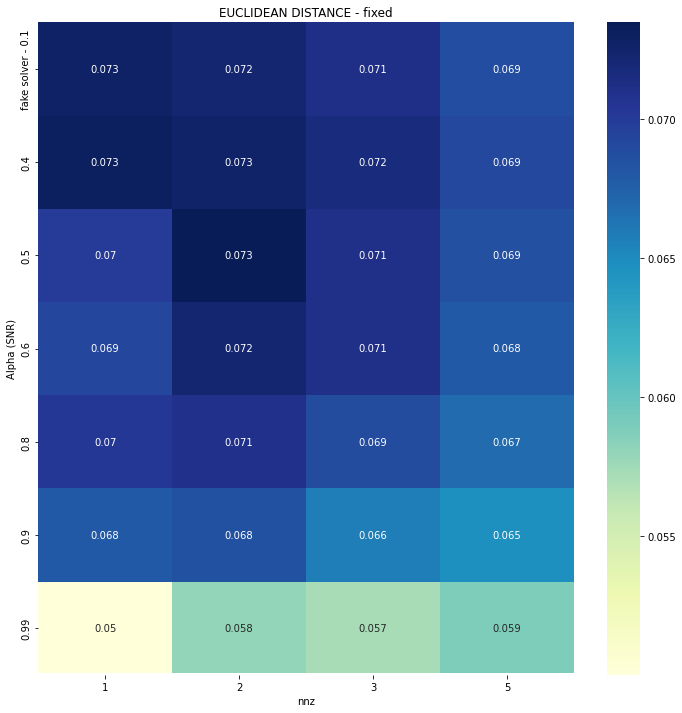

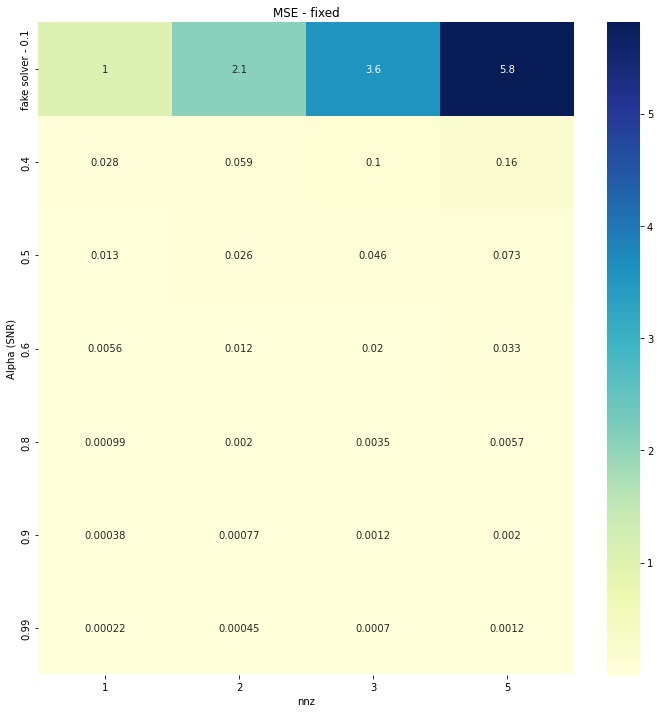

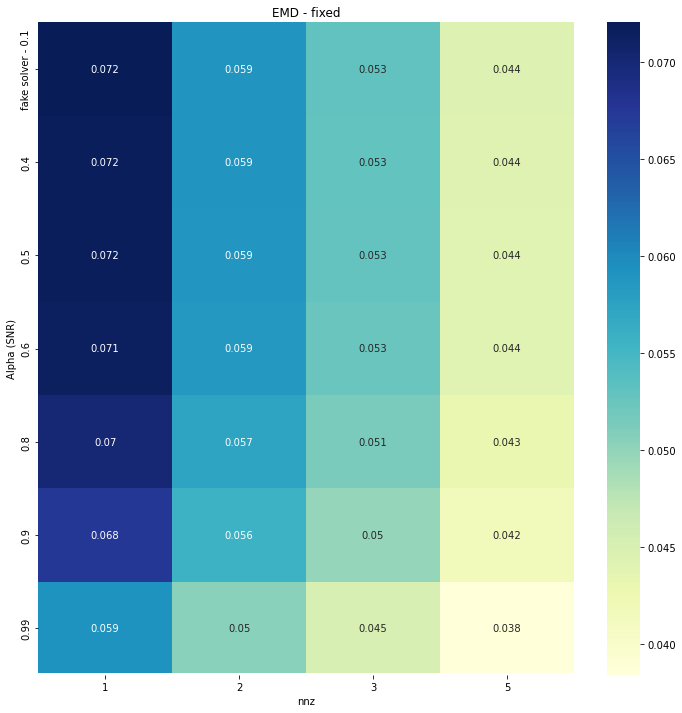

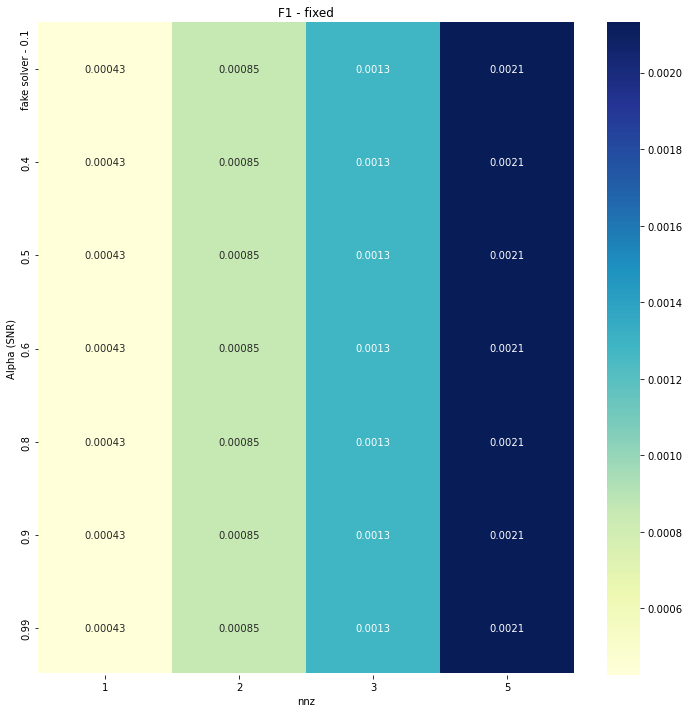

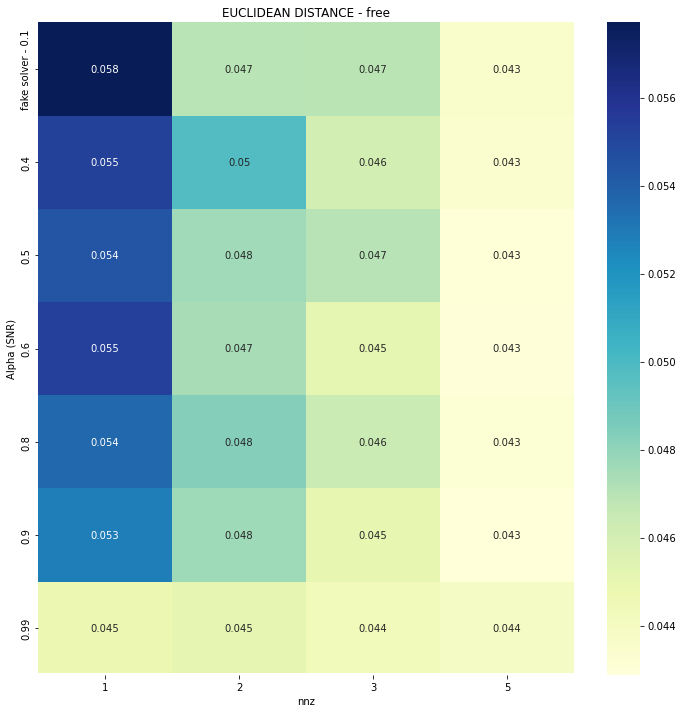

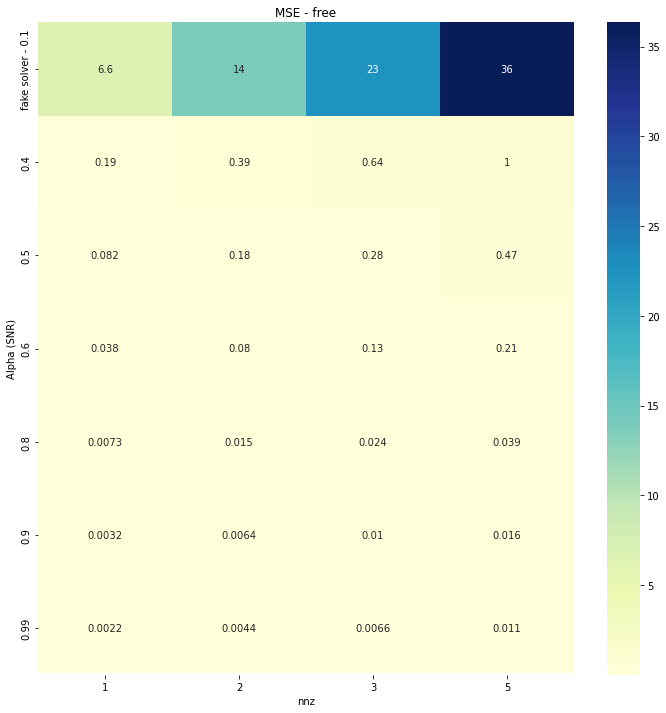

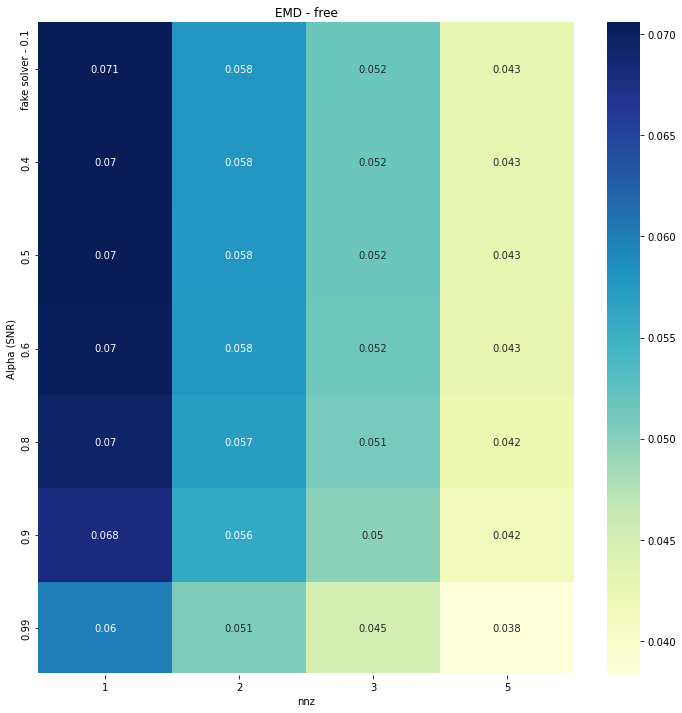

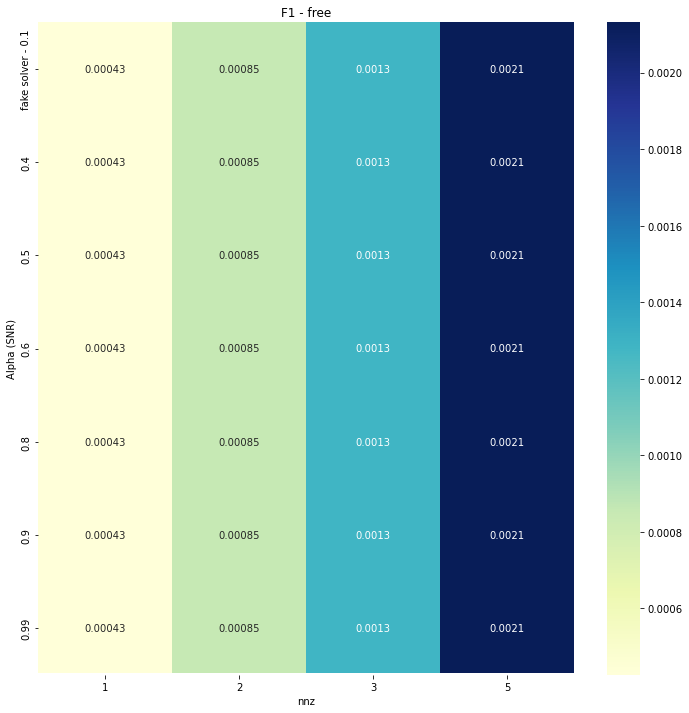

In [41]:
# SNR vs NNZ
for df_results, orientation in zip([df_results_fixed, df_results_free], ["fixed", "free"]):
    for metric in METRIC_NAMES:
        data = df_results.pivot_table(metric, ["estimator", "alpha"], "nnz", aggfunc='mean')

        from collections import OrderedDict
        plt.figure(figsize=(12, 12))
        df=data
        ax = sns.heatmap(df, annot=True, cmap="YlGnBu")

        ylabel_mapping = OrderedDict()
        for estimator, alpha in df.index:
            ylabel_mapping.setdefault(estimator, [])
            ylabel_mapping[estimator].append(alpha)

        hline = []
        new_ylabels = []
        for estimator, alpha_list in ylabel_mapping.items():
            alpha_list[0] = "{} - {}".format(str(estimator).replace("_", " "), alpha_list[0])
            new_ylabels.extend(alpha_list)

            if hline:
                hline.append(len(alpha_list) + hline[-1])
            else:
                hline.append(len(alpha_list))


        ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth=5)
        ax.set_yticklabels(new_ylabels)
        plt.ylabel('Alpha (SNR)')
        plt.title(f'{metric.replace("_", " ").upper()} - {orientation}')
        plt.savefig(f'bsi_zoo/data/figs/SNR_vs_NNZ_{metric}_{orientation}.png')
        plt.show()

In [44]:
# SNR vs estimator alpha plot
# SNR vs NNZ
for df_results, orientation in zip([df_results_fixed, df_results_free], ["fixed", "free"]):
    for metric in METRIC_NAMES:
        try:
            data = df_results.pivot_table(metric, ["estimator", "alpha"], "estimator__alpha_cv", aggfunc='mean')

            from collections import OrderedDict
            plt.figure(figsize=(12, 12))
            df=data
            ax = sns.heatmap(df, annot=True, cmap="YlGnBu")

            ylabel_mapping = OrderedDict()
            for estimator, alpha in df.index:
                ylabel_mapping.setdefault(estimator, [])
                ylabel_mapping[estimator].append(alpha)

            hline = []
            new_ylabels = []
            for estimator, alpha_list in ylabel_mapping.items():
                alpha_list[0] = "{} - {}".format(str(estimator).replace("_", " "), alpha_list[0])
                new_ylabels.extend(alpha_list)

                if hline:
                    hline.append(len(alpha_list) + hline[-1])
                else:
                    hline.append(len(alpha_list))


            ax.hlines(hline, xmin=-1, xmax=4, color="white", linewidth=5)
            ax.set_yticklabels(new_ylabels)
            plt.ylabel('Alpha (SNR)')
            plt.xlabel('Estimator alpha')
            plt.title(f'{metric.replace("_", " ").upper()} - {orientation}')
            plt.savefig(f'bsi_zoo/data/figs/SNR_vs_estimator_alpha_{metric}_{orientation}.png')
            plt.show()
        
        except:
            pass

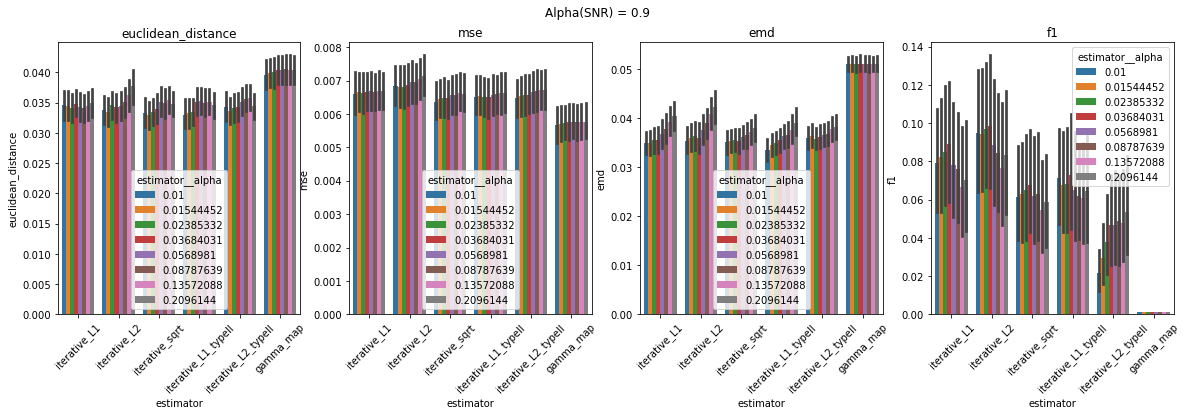

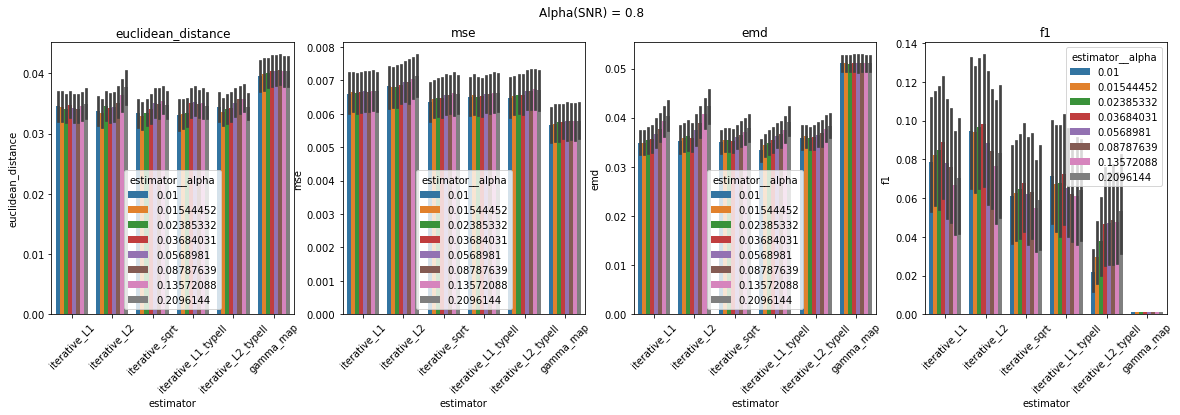

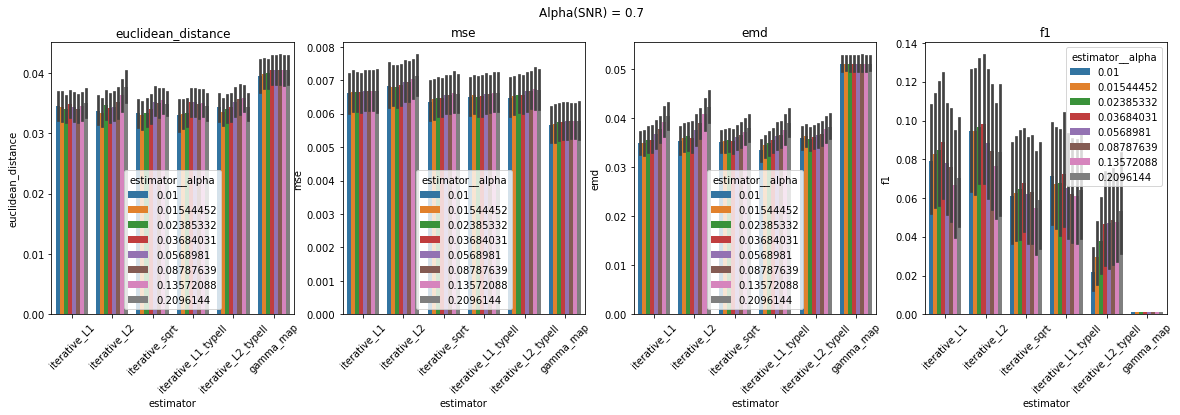

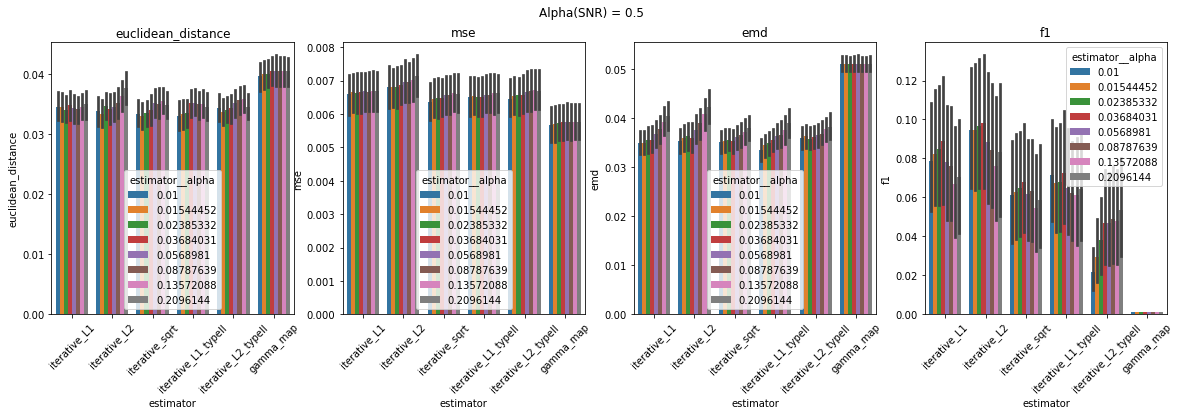

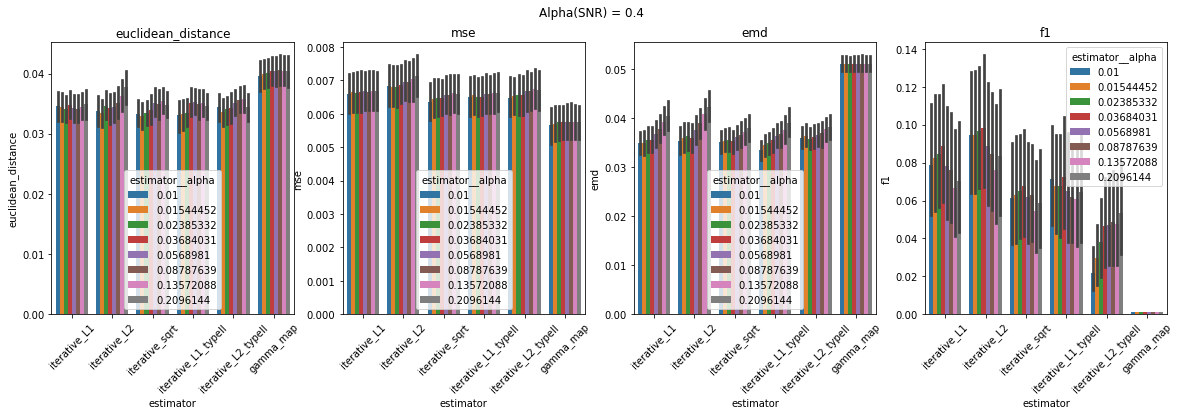

In [7]:
for alpha in df_results["alpha"].unique():
    fig, ax = plt.subplots(1, len(METRIC_NAMES), figsize=(20, 5))
    for i, metric in enumerate(METRIC_NAMES):
        this_df_results = df_results[df_results["alpha"] == alpha]
        sns.barplot(
            data=this_df_results, x="estimator", y=metric, hue="estimator__alpha", ax=ax[i]
        )
        ax[i].set_title(f"{metric}")
        ax[i].tick_params('x', labelrotation=45)

    fig.suptitle(f'Alpha(SNR) = {alpha}')

plt.show()

<Figure size 432x288 with 0 Axes>

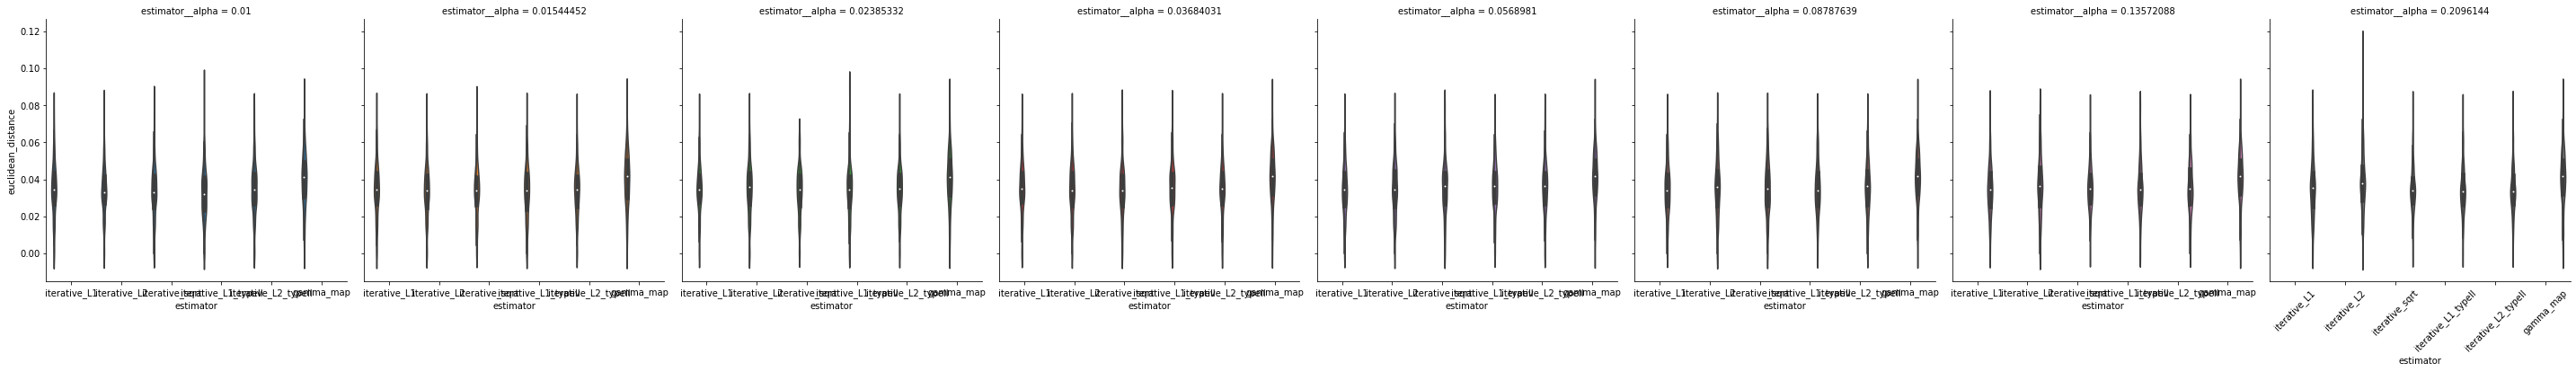

<Figure size 432x288 with 0 Axes>

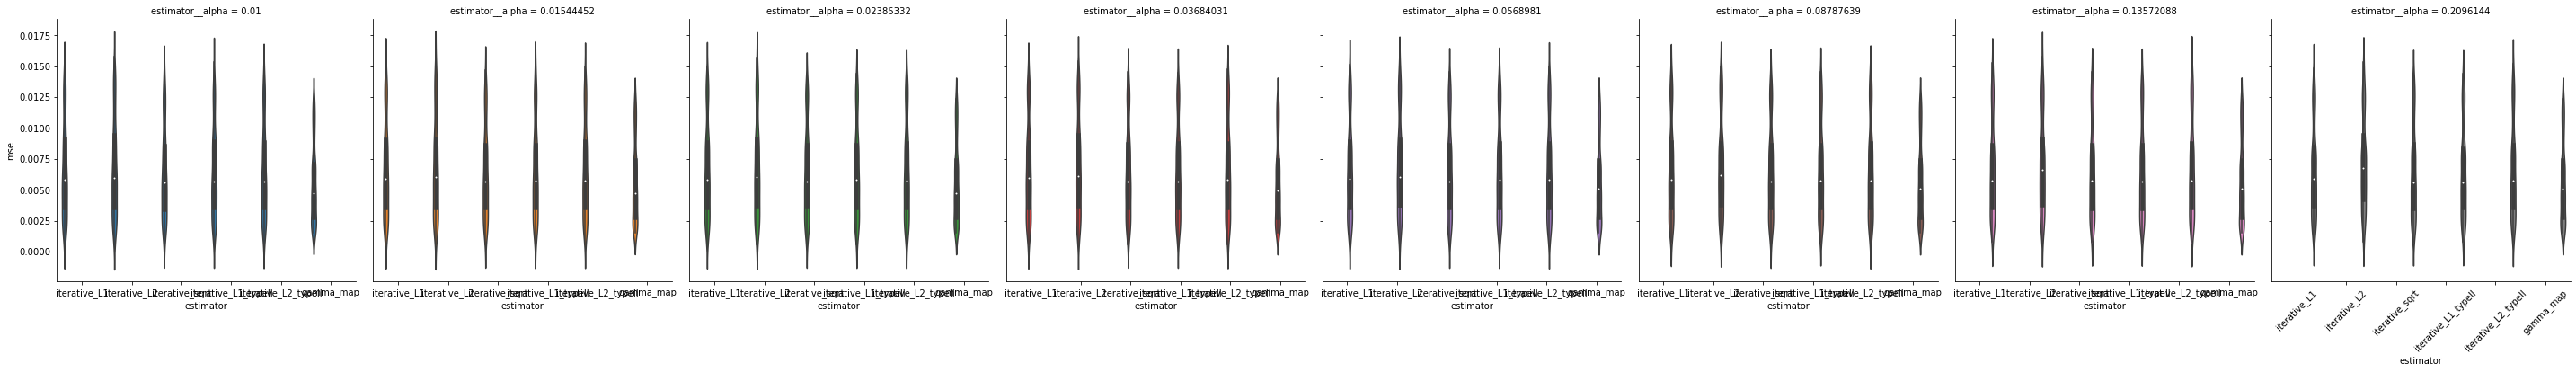

<Figure size 432x288 with 0 Axes>

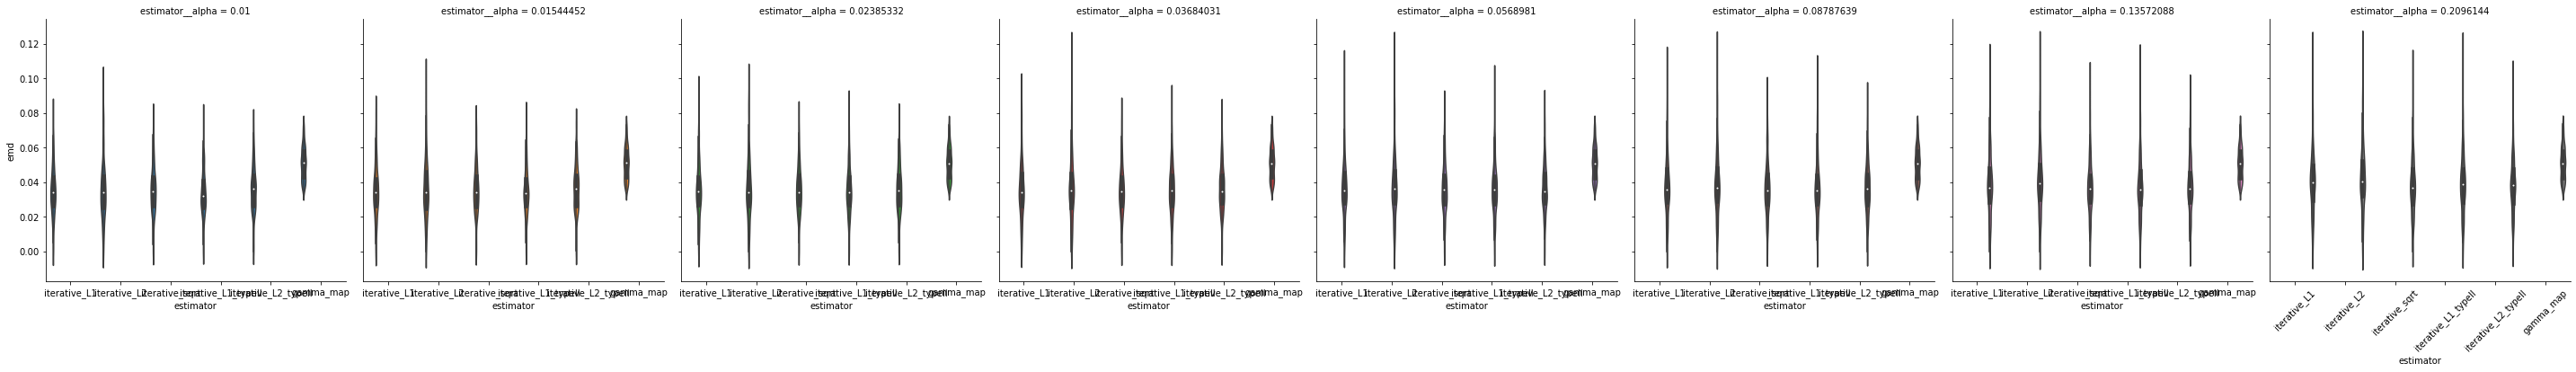

<Figure size 432x288 with 0 Axes>

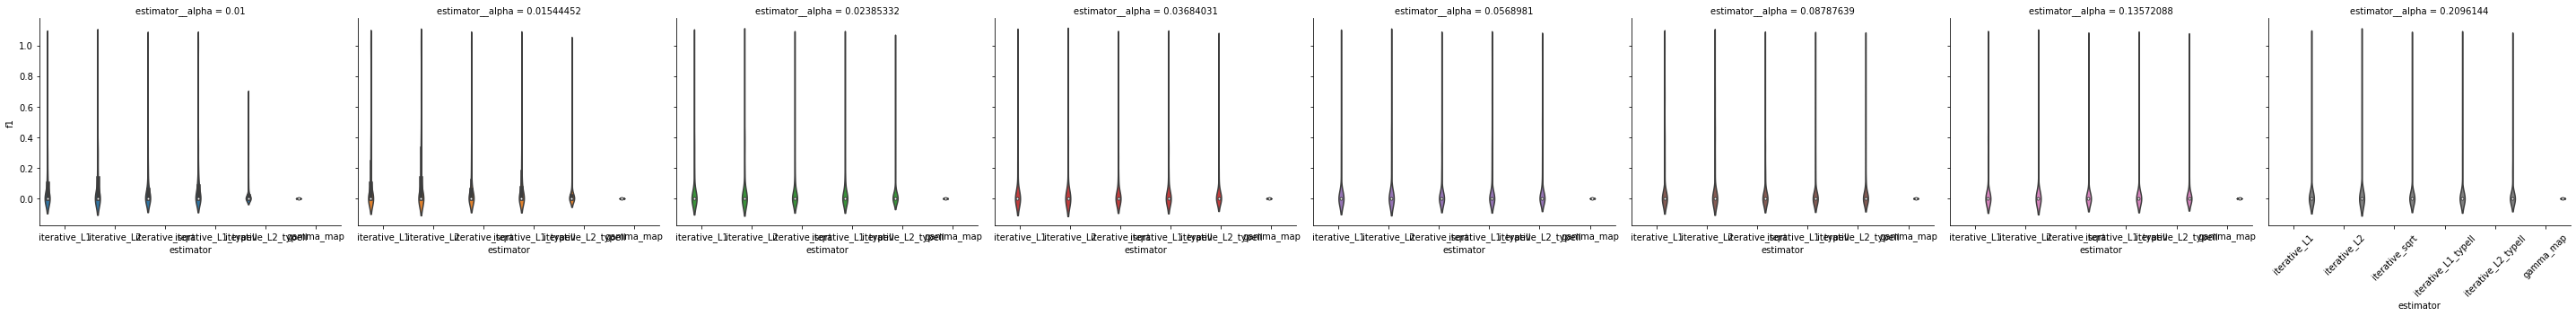

In [8]:
for metric in METRIC_NAMES:
    plt.figure()
    sns.catplot(x="estimator", y=metric, hue="estimator__alpha", data=df_results, ci="sd", kind="violin", col="estimator__alpha")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# def draw_phase_map(val_map, best_map, meth_lab, xlabels, ylabels) :
#     #creation of the figure
#     fig, ax = plt.subplots(figsize=(12, 10))

#     # color map
#     #cmap = sb.diverging_palette(0, 230, 90, 60, as_cmap=True)
#     myColors = ((0.8, 0.0, 0.0, 0.5), (0.0, 0.8, 0.0, 0.5), (0.0, 0.0, 0.8, 0.5),(0.8, 0.8, 0.0, 0.5),(0.8, 0.0, 0.8, 0.5),(0.0, 0.8, 0.8, 0.5))
#     # TODO : Find a better way to generate the right amount of colors
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom', myColors[:len(meth_lab)], len(myColors))

#     # plot heatmap
#     #sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
#     #           linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
#     #           cbar_kws={"shrink": .8}, square=True)
#     ax = sb.heatmap(best_map, annot=val_map, 
#             linewidths=5, cmap=cmap, 
#             cbar_kws={"shrink": .8,'label': 'methods'}, square=True)
    
#     # Manually specify colorbar labelling after it's been generated
#     colorbar = ax.collections[0].colorbar
#     colorbar.set_ticks(np.arange(len(meth_lab)))
#     colorbar.set_ticklabels(meth_lab)

#     # ticks
#     plt.yticks(plt.yticks()[0], labels=ylabels, rotation=0)
#     plt.ylabel('nnz')
#     plt.xticks(plt.xticks()[0], labels=xlabels)
#     plt.xlabel('alpha')

#     # title
#     title = 'Phase Diagram of Metric EMD\nWith a standard Leadfield\n'
#     plt.title(title, loc='left', fontsize=18)

#     # Drawing frontier
#     #sb.lineplot([0,1],[1,1])

#     plt.show()

#     return 

# def select_set(df,orient,est_alpha):
#     return df.loc[(df['orientation_type'] == orient) & (df['estimator__alpha'] == est_alpha)]

# def df_to_matrix(df,alpha_set,nnz_set,metric):
#     mat_from_df = np.zeros((len(nnz_set),len(alpha_set)))
#     for i in range(len(nnz_set)):
#         for j in range(len(alpha_set)):
#             mat_from_df[i,j] = df[(df['nnz'] == nnz_set[i]) & (df['alpha'] == alpha_set[j])][metric]
#     return mat_from_df

# def read_data(df, query):
#     subdf = select_set(df,query[0],query[1])

#     alpha_set = np.sort(subdf['alpha'].unique())
#     nnz_set = np.sort(subdf['nnz'].unique())
#     estimators = subdf['estimator'].unique()

#     val = df_to_matrix(subdf.loc[(subdf['estimator'] == estimators[0])],alpha_set,nnz_set,query[2])
#     phase_map = np.zeros((len(nnz_set),len(alpha_set)))

#     for k in range(1,len(estimators)) :
#         estimator = estimators[k]
#         matrix = df_to_matrix(subdf.loc[(subdf['estimator'] == estimator)],alpha_set,nnz_set,query[2])
#         mask = matrix<val
#         val[mask] = matrix[mask]
#         phase_map[mask] = k
    
#     draw_phase_map(val,phase_map,estimators,alpha_set,nnz_set)
#     return val

In [10]:
# read_data(df_results,['fixed',0.2,'f1'])